# Bayesian Deep Learning

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
Here we collect some codes related to the Bayesian Deep Learning and how to apply it to image recognition and dimensionality reduction of the 10X Mouse Brain Atlas scRNAseq data set. We will use TensorFlow and its Bayesian extension which is called Edward. We will simlate a few 2D examples to demonstrate how to fit simple 2D curves with TensorFlow and Edward.

### Table of Contents:
* [Creating 2D Non-Linear Curve](#Creating 2D Non-Linear Curve)
* [Fitting 2D Non-Linear Curbe with TensorFlow](#Fitting 2D Non-Linear Curbe with TensorFlow)
* [Fitting 2D Non-Linear Curve with Bayesian Neural Network](#Fitting 2D Non-Linear Curve with Bayesian Neural Network)
* [Bayesian Neural Network with Edward](#Bayesian Neural Network with Edward)
* [Autoencodder on MNIST data set](#Autoencodder on MNIST data set)
* [Image Recognition with Bayesian Neural Network](#Image Recognition with Bayesian Neural Network)
* [Bayesian Classification of scRNAseq with Edward](#Bayesian Classification of scRNAseq with Edward)
* [Making your own MCMC sampler](#Making your own MCMC sampler)
* [Fitting with Gaussian Process](#Fitting with Gaussian Process)
* [Classification of scRNAseq with TensorFlow](#Classification of scRNAseq with TensorFlow)
* [Bayesian Classification of scRNAseq with PyMC3 and MCMC Sampler](#Bayesian Classification of scRNAseq with PyMC3 and MCMC Sampler)
* [Bayesian Classification of scRNAseq with PyMC3 and Variational Inference](#Bayesian Classification of scRNAseq with PyMC3 and Variational Inference)

### Creating 2D Non-Linear Curve <a class="anchor" id="Creating 2D Non-Linear Curve"></a>
For now we will start with simulating a toy 2D curve with TensorFlow and fitting it with a simple Multilayer Perceptron neural network:

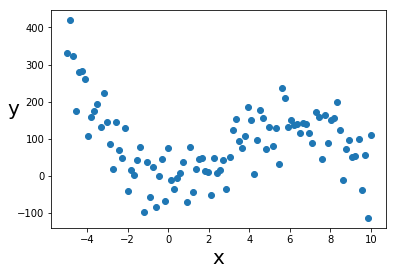

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

N = 100
a = tf.placeholder("float")
b = tf.placeholder("float")
c = tf.placeholder("float")
d = tf.placeholder("float")
x = tf.linspace(-5.0, 10.0, num = N, name = "x")
noise = tf.random_normal(shape = [N,], mean = 0, stddev = 50.0, seed = 1)

# y = a*x^3 + b*x^2 + c*x +d 
with tf.Session() as sess:
    y = sess.run(tf.add(tf.add(tf.add(tf.add(tf.multiply(a,tf.pow(x,3)),tf.multiply(b,tf.pow(x, 2))),tf.multiply(c,x)),d),
                        noise), feed_dict= {a: -1, b: 10, c: 1, d: 1} )
    x = np.reshape(np.array(x.eval()), (N,1))
    y = np.reshape(np.array(y), (N,1))
plt.scatter(x, y)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20, rotation = 0)
plt.show()

### Fitting 2D Non-Linear Curbe with TensorFlow <a class="anchor" id="Fitting 2D Non-Linear Curbe with TensorFlow"></a>
Now let us approximate the simulated 2D non-linear curve with a simple one-hidden-layer neural network built with TensorFlow.

Epoch: 10000 cost =  2618.706542969 b_output =  -4.941221 b_hidden =  -87.24016
Epoch: 20000 cost =  1736.507934570 b_output =  -68.6569 b_hidden =  -121.88881
Epoch: 30000 cost =  1441.302246094 b_output =  -78.15813 b_hidden =  -135.94824
Epoch: 40000 cost =  1372.972656250 b_output =  -83.06546 b_hidden =  -143.4072
Epoch: 50000 cost =  1359.783691406 b_output =  -85.37855 b_hidden =  -148.53316
Epoch: 60000 cost =  1358.229248047 b_output =  -86.38521 b_hidden =  -152.48195
Epoch: 70000 cost =  1358.143066406 b_output =  -86.43292 b_hidden =  -155.76582
Epoch: 80000 cost =  1358.091064453 b_output =  -86.42676 b_hidden =  -158.56989
Epoch: 90000 cost =  1358.059692383 b_output =  -86.42249 b_hidden =  -161.0333
Epoch: 100000 cost =  1358.028442383 b_output =  -86.41855 b_hidden =  -163.2382


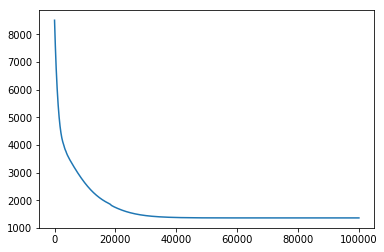

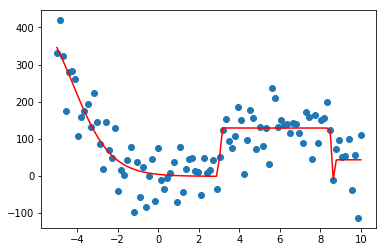

In [409]:
learning_rate = 0.01
training_epochs = 100000
display_step = 10000

n_samples = x.shape[0]      # number of samples, equal N
n_input = 1                 # number of input neurons
n_hidden = 4                # number of hidden neurons

X = tf.placeholder("float")
Y = tf.placeholder("float")

weights = {'w_hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), 
           'w_output': tf.Variable(tf.random_normal([n_hidden, n_input]))}
biases = {'b_hidden': tf.Variable(tf.random_normal([n_hidden])), 
          'b_output': tf.Variable(tf.random_normal([n_input]))}

hidden_layer = tf.nn.sigmoid( tf.add(tf.matmul(X, weights['w_hidden']), biases['b_hidden']) )
output_layer = tf.add(tf.matmul(hidden_layer, weights['w_output']), biases['b_output'])

cost = tf.reduce_sum(tf.pow(output_layer - Y, 2)) / 200
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

my_cost = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        c,_ = sess.run([cost, optimizer], feed_dict={X: x, Y: y})
        my_cost.append(c)
        if (epoch + 1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost = ", "{:.9f}".format(c),
                  "b_output = ", sess.run(biases['b_output'][0]), "b_hidden = ", sess.run(biases['b_hidden'][0]))
    pred = sess.run(output_layer, feed_dict={X: x})
plt.plot(range(training_epochs), my_cost)
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20, rotation = 1)
plt.show()

plt.scatter(x, y)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20, rotation = 0)
plt.plot(x, pred, c = 'r')
plt.show()

### Fitting 2D Non-Linear Curve with Bayesian Neural Network <a class="anchor" id="Fitting 2D Non-Linear Curve with Bayesian Neural Network"></a>
Now for comparison we will create an analagous model using Bayesian alternative of TensorFflow which is Edward. The syntax of Edward is very close to the TensorFlow's syntax, we will use exactly the same architecture of the neural network as above. The main difference is that we put Priors on all the weights and biases.

In [2]:
from edward.models import Normal

n_input = 1                 # number of input neurons
n_hidden = 64               # number of hidden neurons

W_0 = Normal(loc=tf.zeros([n_input, n_hidden]), scale=tf.ones([n_input, n_hidden]))
W_1 = Normal(loc=tf.zeros([n_hidden, n_input]), scale=tf.ones([n_hidden, n_input]))
b_0 = Normal(loc=tf.zeros(n_hidden), scale=tf.ones(n_hidden))
b_1 = Normal(loc=tf.zeros(n_input), scale=tf.ones(n_input))

x_train = x
y_train = Normal(loc=tf.matmul(tf.sigmoid(tf.matmul(x_train, W_0) + b_0), W_1) + b_1,
           scale = 5*tf.ones(1))

qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [n_input, n_hidden]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [n_input, n_hidden])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [n_hidden, n_input]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [n_hidden, n_input])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [n_hidden]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [n_hidden])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [n_input]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [n_input])))

Now we will run variational Bayes inference with Kullback-Leibler divergence:

In [3]:
import edward as ed

inference = ed.KLqp({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1}, data={y_train: y})

inference.run(n_iter = 1000, n_samples = 20)

/home/nikolay/miniconda3/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 9847.334


Now let us sample the posterior curves and check how they fit the 2D curve:

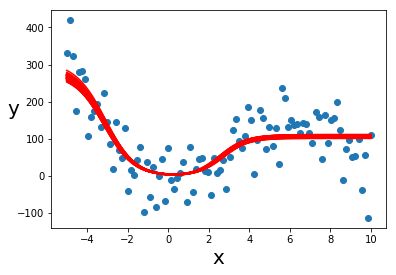

In [4]:
def neural_network(x, W_0, W_1, b_0, b_1):
  h = tf.matmul(tf.sigmoid(tf.matmul(x, W_0) + b_0), W_1) + b_1
  return tf.reshape(h, [-1])

mus = []
for s in range(100):
    mus.append(neural_network(x_train, qW_0.sample(), qW_1.sample(), qb_0.sample(), qb_1.sample()))
mus = tf.stack(mus)

plt.scatter(x, y)
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20, rotation = 0)
for i in range(100):
    plt.plot(x, mus.eval()[i], c = 'r')
plt.show()

### Bayesian Neural Network with Edward <a class="anchor" id="Bayesian Neural Network with Edward"></a>
Her we will reproduce the Getting Started example a the Edward's web-page. We start with buildin the toy data set and defining the Neural Network:

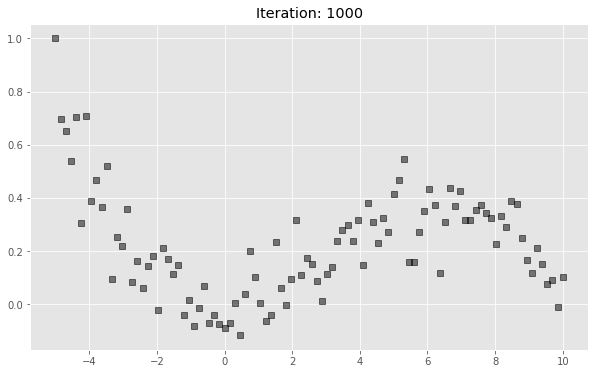

In [1]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal, Uniform

plt.style.use('ggplot')

ed.set_seed(1)

def build_toy_dataset(N = 100, noise_std = 50.0):
  x = np.linspace(-5, 10, num = N)
  y = (-1)*pow(x,3) + 10*pow(x,2) + x + 1 + np.random.normal(0, noise_std, size = N)
  x = x.astype(np.float32).reshape((N, 1))
  y = y.astype(np.float32)
  return x, y/np.max(y)

def neural_network(x, W_0, W_1, b_0, b_1):
  h = tf.sigmoid(tf.matmul(x, W_0) + b_0)
  h = tf.matmul(h, W_1) + b_1
  return tf.reshape(h, [-1])

N = 100        # number of data points
D = 1          # number of features
n_hidden = 8   # number of hidden neurons

x_train, y_train = build_toy_dataset(N)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
plt.show()

Next, we define weights and biases of the Neural Network applying Prior ditributions. We will use variational inference and specify approximations for the weights and biases:

In [2]:
W_0 = Normal(loc=tf.zeros([D, n_hidden]), scale=tf.ones([D, n_hidden]))
W_1 = Normal(loc=tf.zeros([n_hidden, D]), scale=tf.ones([n_hidden, D]))
b_0 = Normal(loc=tf.zeros(n_hidden), scale=tf.ones(n_hidden))
b_1 = Normal(loc=tf.zeros(D), scale=tf.ones(D))

x = x_train
y = Normal(loc = neural_network(x, W_0, W_1, b_0, b_1),
           scale = 0.1 * tf.ones(N))

qW_0 = Normal(loc=tf.get_variable("qW_0/loc", [D, n_hidden]),
              scale=tf.nn.softplus(tf.get_variable("qW_0/scale", [D, n_hidden])))
qW_1 = Normal(loc=tf.get_variable("qW_1/loc", [n_hidden, D]),
              scale=tf.nn.softplus(tf.get_variable("qW_1/scale", [n_hidden, D])))
qb_0 = Normal(loc=tf.get_variable("qb_0/loc", [n_hidden]),
              scale=tf.nn.softplus(tf.get_variable("qb_0/scale", [n_hidden])))
qb_1 = Normal(loc=tf.get_variable("qb_1/loc", [D]),
              scale=tf.nn.softplus(tf.get_variable("qb_1/scale", [D])))

Now we will sample curves from the Posterior distributions of weights and biases and visualize the posterior fits:

In [3]:
# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 10, num = 500, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack([neural_network(x, qW_0.sample(), qW_1.sample(), qb_0.sample(), qb_1.sample()) for _ in range(100)])

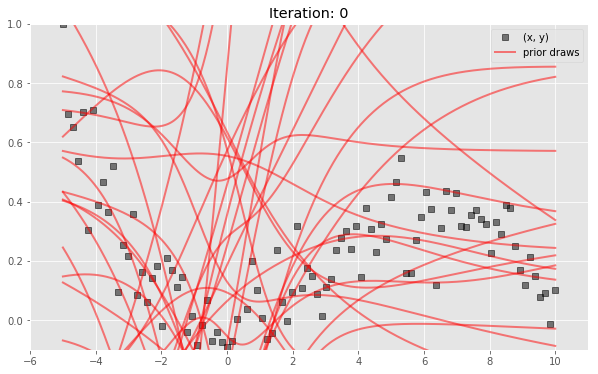

In [4]:
# FIRST VISUALIZATION (prior)

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-6, 11])
ax.set_ylim([-0.1, 1])
ax.legend()
plt.show()

In [5]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter = 1000, n_samples = 100)

1000/1000 [100%] ██████████████████████████████ Elapsed: 27s | Loss: -14.489


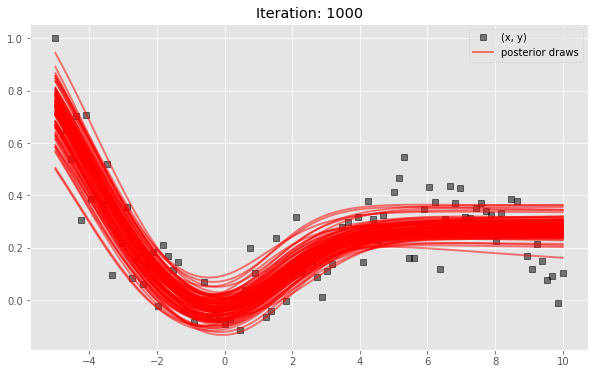

In [6]:
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.legend()
plt.show()

### Autoencoder on scRNAseq data <a class="anchor" id="Autoencoder on scRNAseq data"></a>
Here we will show how to implement an Autoencoder in TensorFlow for scRNAseq data set from K. Pietras project:

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# READ DATA
expr = pd.read_csv('/home/nikolay/WABI/K_Pietras/Manifold_Learning/bartoschek_filtered_expr_rpkm.txt', sep='\t')
print("\n" + "Dimensions of input file: " + str(expr.shape) + ", that means you have " + str(expr.shape[0]) + 
      " cells and " + str(expr.shape[1]) + " genes remained after filtering" + "\n")
print("\n" + "A few first lines of input file: " + "\n")
print(expr.iloc[0:4, 0:4])
print("\n" + "Last column corresponds to cluster assignments: " + "\n")
print(expr.iloc[0:4, (expr.shape[1]-4):expr.shape[1]])

# LOG-TRANSFORM DATA
X = expr.values[:,0:(expr.shape[1]-1)]
Y = expr.values[:,expr.shape[1]-1]
print("\n" + "A few cluster labels: " + "\n")
print(Y[0:8])
print("\n" + "Number of unique clusters: " + str(len(set(Y))) + "\n")
print("\n" + "You have following unique cluster labels: " + "\n")
print(set(Y))
print("\n" + "Log-transforming data..." + "\n")
X = np.log(X + 1)


Dimensions of input file: (716, 558), that means you have 716 cells and 558 genes remained after filtering


A few first lines of input file: 

                1110020A21Rik  1110046J04Rik  1190002F15Rik  1500015A07Rik
SS2_15_0048_A3            0.0            0.0            0.0            0.0
SS2_15_0048_A6            0.0            0.0            0.0            0.0
SS2_15_0048_A5            0.0            0.0            0.0            0.0
SS2_15_0048_A4            0.0            0.0            0.0            0.0

Last column corresponds to cluster assignments: 

                Zfp652os  Zfp81  Zfp944  cluster
SS2_15_0048_A3       0.0    0.0     0.0        1
SS2_15_0048_A6       0.0    0.0     0.0        1
SS2_15_0048_A5       0.0    0.0     0.0        1
SS2_15_0048_A4       0.0    0.0     0.0        2

A few cluster labels: 

[ 1.  1.  1.  2.  1.  2.  2.  4.]

Number of unique clusters: 4


You have following unique cluster labels: 

{1.0, 2.0, 3.0, 4.0}

Log-transforming data...



Here we are going to define hyperparameters of the autoencoder neural network, it will have three hidden layers, the input layer has 557 dimensions (557 genes in the scRNAseq data set), first and last hidden layer have 100 nodes and the middle hidden layer, i.e. the bottleneck, contains 2 hidden nodes:

In [8]:
# Training Parameters
learning_rate   = 0.0001
training_epochs = 20000
display_step    = 1000

# Network Parameters
num_hidden_1   = 100            # 1st layer num features
num_hidden_2   = 20             # 2nd layer num features
num_bottleneck = 2              # 2nd layer num features
num_input      = X.shape[1]     # scRANAseq data input (number of features / genes)

Next, we define weights and biases of the autoencoder which we initialize by random Normal values:

In [3]:
# tf Graph input
x = tf.placeholder("float")
y = tf.placeholder("float")

weights = {
    'encoder_h1':  tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2':  tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'bottleneck':  tf.Variable(tf.random_normal([num_hidden_2, num_bottleneck])),
    'decoder_h1':  tf.Variable(tf.random_normal([num_bottleneck, num_hidden_2])),
    'decoder_h2':  tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_out': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1':  tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2':  tf.Variable(tf.random_normal([num_hidden_2])),
    'bottleneck':  tf.Variable(tf.random_normal([num_bottleneck])),
    'decoder_b1':  tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b2':  tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_out': tf.Variable(tf.random_normal([num_input])),
}

Next, we define encoder and decoder of the autoencoder, we will use sigmoid activation functions:

In [4]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    # Encoder Bottleneck
    bottleneck = tf.add(tf.matmul(layer_2, weights['bottleneck']), biases['bottleneck'])
    return bottleneck

# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    # Decoder Hidden layer with sigmoid activation #3
    layer_out = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_out']), biases['decoder_out']))
    return layer_out

Construct and compile the model with Adam optimizer:

In [5]:
# Construct model
encoder_op = encoder(x)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = x

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

And start training with TensorFlow:

Epoch: 1000 cost =  4.658809662
Epoch: 2000 cost =  4.640718460
Epoch: 3000 cost =  4.610218048
Epoch: 4000 cost =  4.602231026
Epoch: 5000 cost =  4.587130070
Epoch: 6000 cost =  4.576281071
Epoch: 7000 cost =  4.531865597
Epoch: 8000 cost =  4.512635231
Epoch: 9000 cost =  4.508876324
Epoch: 10000 cost =  4.505082607
Epoch: 11000 cost =  4.501372337
Epoch: 12000 cost =  4.498193264
Epoch: 13000 cost =  4.497268677
Epoch: 14000 cost =  4.496814728
Epoch: 15000 cost =  4.496814728
Epoch: 16000 cost =  4.496814728
Epoch: 17000 cost =  4.496814728
Epoch: 18000 cost =  4.496814728
Epoch: 19000 cost =  4.496814728
Epoch: 20000 cost =  4.496814728


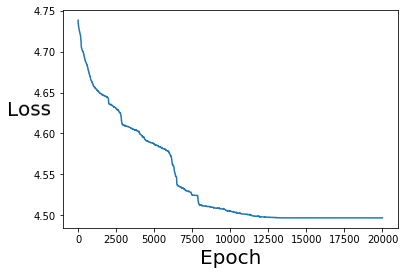

In [9]:
my_cost = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        c,_ = sess.run([cost, optimizer], feed_dict={x: X, y: Y})
        my_cost.append(c)
        if (epoch + 1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost = ", "{:.9f}".format(c))
    pred = sess.run(encoder(x), feed_dict={x: X})
            
plt.plot(range(training_epochs), my_cost)
plt.xlabel("Epoch",fontsize = 20)
plt.ylabel("Loss",fontsize = 20, rotation = 1)
plt.show()

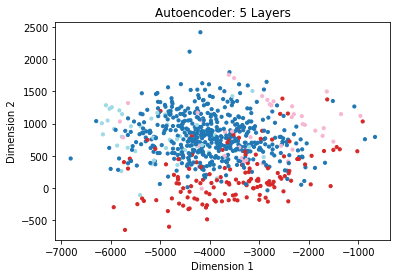

In [10]:
plt.scatter(pred[:,0], pred[:,1], c = Y, s = 10, cmap = 'tab20')
plt.title('Autoencoder: 5 Layers')
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### Autoencodder on MNIST data set <a class="anchor" id="Autoencodder on MNIST data set"></a>
We will start with importing important modules:

In [5]:
import edward as ed
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

He we will use MNIST data set, let us download it:

In [6]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Here we are going to define hyperparameters of the autoencoder neural network, it will have three hidden layers, the input layer has 784 dimensions (28 pixel times 28 pixels), first and last hidden layer have 256 nodes and the middle hidden layer, i.e. the bottleneck, contains 128 hidden nodes:

In [8]:
# Training Parameters
learning_rate = 0.01
num_steps = 30000
batch_size = 256

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = 784 # MNIST data input (img shape: 28*28)

Next, we define weights and biases of the autoencoder which we initialize by random Normal values:

In [9]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

Next, we define encoder and decoder of the autoencoder, we will use sigmoid activation functions:

In [10]:
# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

Construct and compile the model with RMSProp optimizer:

In [11]:
# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

And start training:

Step 1: Minibatch Loss: 0.430437
Step 1000: Minibatch Loss: 0.144039
Step 2000: Minibatch Loss: 0.120672
Step 3000: Minibatch Loss: 0.112878
Step 4000: Minibatch Loss: 0.107982
Step 5000: Minibatch Loss: 0.102437
Step 6000: Minibatch Loss: 0.102507
Step 7000: Minibatch Loss: 0.096722
Step 8000: Minibatch Loss: 0.095882
Step 9000: Minibatch Loss: 0.093186
Step 10000: Minibatch Loss: 0.094601
Step 11000: Minibatch Loss: 0.087017
Step 12000: Minibatch Loss: 0.087799
Step 13000: Minibatch Loss: 0.081830
Step 14000: Minibatch Loss: 0.082213
Step 15000: Minibatch Loss: 0.081765
Step 16000: Minibatch Loss: 0.077924
Step 17000: Minibatch Loss: 0.077377
Step 18000: Minibatch Loss: 0.075494
Step 19000: Minibatch Loss: 0.075952
Step 20000: Minibatch Loss: 0.070451
Step 21000: Minibatch Loss: 0.071347
Step 22000: Minibatch Loss: 0.069771
Step 23000: Minibatch Loss: 0.068638
Step 24000: Minibatch Loss: 0.069835
Step 25000: Minibatch Loss: 0.067910
Step 26000: Minibatch Loss: 0.064601
Step 27000: Mi

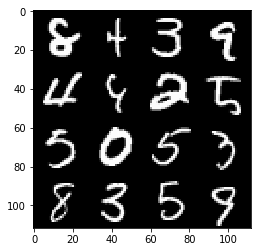

Reconstructed Images


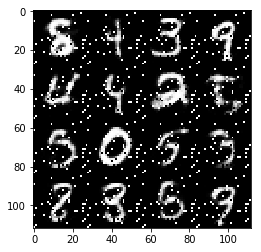

In [12]:
# Start Training
# Start a new TF session
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)

        # Run optimization op (backprop) and cost op (to get loss value)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))

    # Testing
    # Encode and decode images from test set and visualize their reconstruction.
    n = 4
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    for i in range(n):
        # MNIST test set
        batch_x, _ = mnist.test.next_batch(n)
        # Encode and decode the digit image
        g = sess.run(decoder_op, feed_dict={X: batch_x})

        # Display original images
        for j in range(n):
            # Draw the original digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                batch_x[j].reshape([28, 28])
        # Display reconstructed images
        for j in range(n):
            # Draw the reconstructed digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = \
                g[j].reshape([28, 28])

    print("Original Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

### Image Recognition with Bayesian Neural Network <a class="anchor" id="Image Recognition with Bayesian Neural Network"></a>
Here we are going to explain how using Bayesian Neural Network can improve MNIST image classification. We will start with extracting MNIST images and preparing necessary modules:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [2]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Here we will use Normal Priors for weights and biases and Categorical likelihood for classification:

In [3]:
ed.set_seed(314159)
N = 100   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x, w) + b)

According to the idea of variational Bayes inference we will define approximations for the weights and biases:

In [4]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K]))))
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

and use Kullback-Leibler divergence to minimize the distance between p and q spaces:

In [8]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y: y_ph})
# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 9s | Loss: 31036.822


Let us now evaluate our model using test data set:

In [10]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels, axis = 1)

We will draw 100 samples from the Posterior and compute the distribution of accuracies of predictions:

In [11]:
# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul( X_test,w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())

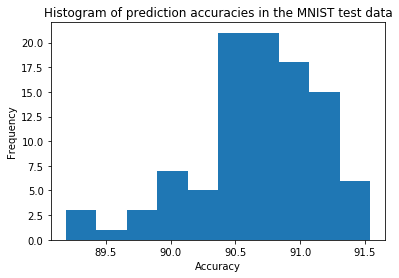

In [12]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

We can perform a model averaging and try to get a equivalent of a classical machine learning model. We do this by stacking up the predictions of the 100 samples we took from the posterior distribution and then computing the average of the predictions.

In [13]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("Accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

Accuracy in predicting the test data =  92.41


Let us visualize posterior distributions of the weights and biases:

/home/nikolay/miniconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


Text(0.5,0.98,'Joint posterior distribution of the first 5 weights')

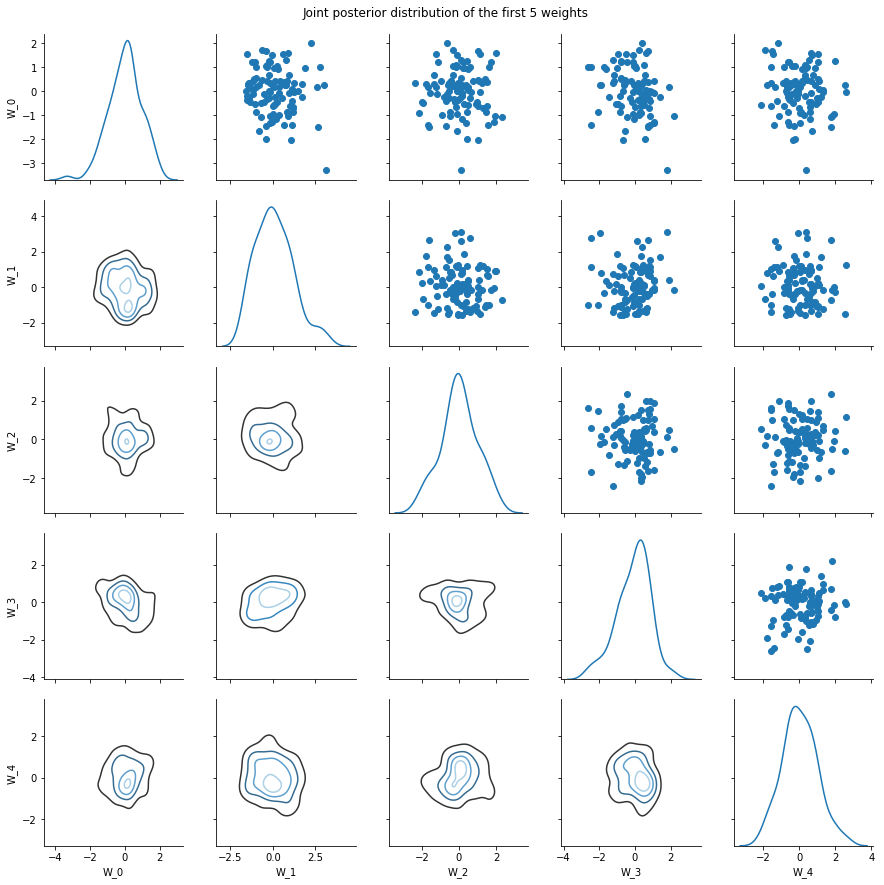

In [14]:
# Create a Pandas DataFrame of posterior samples.
samples_df = pd.DataFrame(data = samples, index=range(n_samples))
# Now create a small subset by taking the first 5 weights, labelled as W_0, ... , W_4.
samples_5 = pd.DataFrame(data = samples_df[list(range(5))].values,columns=["W_0", "W_1", "W_2", "W_3", "W_4"])
# We use Seaborn PairGrid to make a triale plot to show auto and cross correlations.
g = sns.PairGrid(samples_5, diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,legend=False)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Joint posterior distribution of the first 5 weights')

We load up an image from the test data and see what classification we get for each sample from the posterior distribution of weights and biases.

Truth =  7


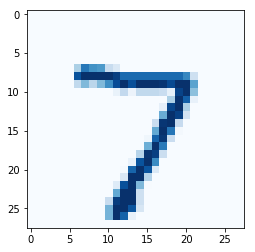

In [15]:
# Load the first image from the test data and its label.
test_image = X_test[0:1]
test_label = Y_test[0]
print('Truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

Now let us check what the model predictes from the posterior distribution:

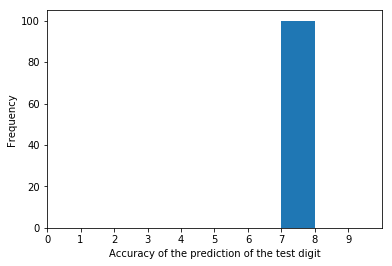

In [16]:
# Now the check what the model perdicts for each (w,b) sample from the posterior. This may take a few seconds...
sing_img_probs = []
for w_samp, b_samp in zip(w_samples, b_samples):
    prob = tf.nn.softmax(tf.matmul( X_test[0:1], w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")
plt.show()

So the model was very sure that the digit on the picture was 7. Now what happens if we show some letter which is drawn in the same hand-written style as MNIST. This is done to confuse the model and test how uncertain the model can be if you show completely unfamiliar data to the model:

In [17]:
# As the nonMNIST data is in the same format as MNIST, we can use the TensorFlow functions.
# Please make sure that notMNIST_data directory is in the same directory as this notebook.
# Otherwise, please provide the full path.

### Note that if you haven't executed the bash commands above, TensorFlow method
### WILL download the MNIST data into notMNIST data below and you will get the 
### digit 7 as the first number!
not_mnist = input_data.read_data_sets("/tmp/data/notMNIST-to-MNIST/", one_hot=True)

Extracting /tmp/data/notMNIST-to-MNIST/train-images-idx3-ubyte.gz
Extracting /tmp/data/notMNIST-to-MNIST/train-labels-idx1-ubyte.gz
Extracting /tmp/data/notMNIST-to-MNIST/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/notMNIST-to-MNIST/t10k-labels-idx1-ubyte.gz


Truth =  3


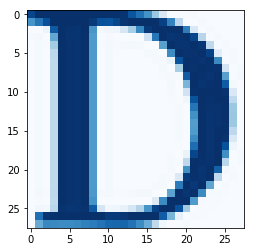

In [18]:
# Load the test images from the data and their lables. 
Xnm_test = not_mnist.test.images
# Once again convert one-hot-vector to the corresponding labels.
Ynm_test = np.argmax(not_mnist.test.labels,axis=1)
# Load the first image from the notMNIST.
test_image = Xnm_test[0]
test_label = Ynm_test[0]
print('Truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

Let us now test how the model predicts the digit in the picture:

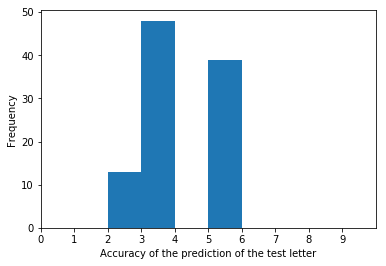

In [19]:
# As before, compute the proabilities for each class for all (w,b) samples from the posterior.
nm_sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( Xnm_test[0:1],w_samp ) + b_samp)
    nm_sing_img_probs.append(prob.eval())
# Now compute the histogram of perdictions from the (w,b) samples.
# In our previous test, all the weights from the posterior was able get the correct prediction.
# However, here we see that the model gives a wide range of possibilites.
# Hence we conclude that its cofidence is lower. 
plt.hist(np.argmax(nm_sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test letter")
plt.ylabel("Frequency")
plt.show()

This histogram shows that the model is not as confident as before about the new classification. This is where the Bayesian methods can add a lot of value compared to the traditional ML methods. What we have shown here is that the posterior distribution of weights can be used to check the confidence with which the network can classify objects.

### Bayesian Classification of scRNAseq with Edward <a class="anchor" id="Bayesian Classification of scRNAseq with Edward"></a>
In this section we will apply Bayesian Neural Netrwok created in Edward to a classifiaction problem, namely we will try the model to recognize subtypes of Cancer Associated Fibroblasts (CAFs) from the scRNAseq project of K. Pietras from Lund University. Later we will include fibroblasts from another scRNAseq data set (different technology, different organism) and non-fibroblast cells and demonstrate the model's higher uncertanty in assigning those cells to one of the CAF clusters.

In [1]:
import pandas as pd
cafs = pd.read_csv('/home/nikolay/WABI/K_Pietras/CRC/CAFs_XGBoost.txt',sep='\t')
crc_fibro = pd.read_csv('/home/nikolay/WABI/K_Pietras/CRC/CRC_FIBRO_RF.txt',sep='\t')
crc_all_cells_minus_fibro = pd.read_csv('/home/nikolay/WABI/K_Pietras/CRC/CRC_ALL_CELLS_MINUS_FIBRO_RF.txt',sep='\t')
print('CAFs data set has dimensions: {}'.format(cafs.shape))
print('CRC fibroblast data set has dimensions: {}'.format(crc_fibro.shape))
print('CRC other cells data set has dimensions: {}'.format(crc_all_cells_minus_fibro.shape))

CAFs data set has dimensions: (716, 9202)
CRC fibroblast data set has dimensions: (17, 9201)
CRC other cells data set has dimensions: (347, 9201)


In [2]:
cafs.iloc[0:5,0:10]

,TRAPPC2,KIAA0141,KIAA1841,C17orf49,NCBP2.AS2,C2orf68,C1orf123,C21orf59,C11orf58,TGIF2.C20orf24
SS2_15_0048_A3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.292250,0.000000
SS2_15_0048_A6,0.000000,0.000000,0.000000,19.807819,0.000000,0.000000,0.000000,0.000000,132.429416,0.000000
SS2_15_0048_A5,0.000000,2.190080,0.000000,0.000000,0.000000,0.000000,0.000000,76.368453,0.000000,55.859441
SS2_15_0048_A4,0.000000,3.314831,19.843349,28.724288,76.155489,1.611635,110.748706,0.000000,69.348639,0.000000
SS2_15_0048_A1,33.807347,87.979006,0.000000,0.000000,0.000000,0.000000,12.996538,31.776145,86.389846,63.388776


In [3]:
import numpy as np
np.random.seed(1)
samples_to_select = list(np.random.choice(list(cafs.index), 17, replace=False))
samples_to_keep = [i for i in list(cafs.index) if i not in samples_to_select]
print('We will randomply select {} samples'.format(len(samples_to_select)))
print('And keep the rest {} samples'.format(len(samples_to_keep)))
cafs_test = cafs.loc[samples_to_select,:]
X_cafs_test = cafs_test.values[:,0:(cafs.shape[1]-1)]
Y_cafs_test = cafs_test.values[:,cafs.shape[1]-1]
cafs_train = cafs.loc[samples_to_keep,:]
X_cafs_train = cafs_train.values[:,0:(cafs.shape[1]-1)]
Y_cafs_train = cafs_train.values[:,cafs.shape[1]-1]

We will randomply select 17 samples
And keep the rest 699 samples


In [4]:
X_cafs_train.shape

(699, 9201)

In [5]:
Y_cafs_train.shape

(699,)

Let us randomly select 17 cells other than fibroblasts from the Colorectal Cancer (CRC) data set. We will use them for comparision of the classification results with the 17 fibroblasts from the the same data set using the Bayesian Neural Network trained on the CAFs data set. The hypothesis is that fibroblasts from the CRC data set will have a higher uncertainty of prediction compared to the native 17 test CAFs, and the non-fibroblast cells from the CRC data set will have even higher uncertanty of classification, i.e. the model will say "I do not know how to classify those 17 non-fibroblast cells because I was trained in fibroblasts only".

In [6]:
nonfibro_samples_to_select = list(np.random.choice(list(crc_all_cells_minus_fibro.index), 17, replace=False))
crc_all_cells_minus_fibro = crc_all_cells_minus_fibro.loc[nonfibro_samples_to_select,:]

In [7]:
crc_fibro = crc_fibro.values
crc_all_cells_minus_fibro = crc_all_cells_minus_fibro.values

In [8]:
nonfibro_samples_to_select

['RHL2718__Epithelial__#2749FE',
 'RHC3641__Epithelial__#2749FE',
 'RHC4935__Epithelial__#2749FE',
 'RHC3898__Epithelial__#2749FE',
 'RHC3907__Macrophage__#FFFF55',
 'RHC5613__Epithelial__#2749FE',
 'RHC3844__Epithelial__#2749FE',
 'RHL2749__Epithelial__#2749FE',
 'RHC4897__Bcell__#7DEA7B',
 'RHL2779__Epithelial__#2749FE',
 'RHL2780__Epithelial__#2749FE',
 'RHC5586__Epithelial__#2749FE',
 'RHC4130__Epithelial__#2749FE',
 'RHC4045__MastCell__#E596C5',
 'RHC3596__Bcell__#7DEA7B',
 'RHC3640__Epithelial__#2749FE',
 'RHC4050__Epithelial__#2749FE']

Now X_cafs_test, crc_fibro and crc_all_cells_minus_fibro should have 17 cells each:

In [9]:
print('CAFs test data set has dimensions: {}'.format(X_cafs_test.shape))
print('CRC fibroblast data set has dimensions: {}'.format(crc_fibro.shape))
print('CRC other cells data set has dimensions: {}'.format(crc_all_cells_minus_fibro.shape))

CAFs test data set has dimensions: (17, 9201)
CRC fibroblast data set has dimensions: (17, 9201)
CRC other cells data set has dimensions: (17, 9201)


Let us proceed with one-hot encoding the labels of the train and test CAFs data sets, in case Edward does not need it we will keep the original label codes in Y_cafs_train_original and Y_cafs_test_original:

In [10]:
from sklearn.preprocessing import label_binarize
Y_cafs_train_original = Y_cafs_train
Y_cafs_train = label_binarize(Y_cafs_train, classes = [0, 1, 2, 3])
Y_cafs_test_original = Y_cafs_test
Y_cafs_test = label_binarize(Y_cafs_test, classes = [0, 1, 2, 3])

Now let us make our Variational Inference model of Bayesian Neural Network in Edward:

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [12]:
n_samples = X_cafs_train.shape[0]      # number of samples
n_input = X_cafs_train.shape[1]        # number of input neurons (features)
n_classes = Y_cafs_train.shape[1]      # number of classes
n_hidden = 64                          # number of hidden neurons

# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [n_samples, n_input])
y = tf.placeholder(tf.float32, [n_samples, n_classes])

# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w_hidden = Normal(loc = tf.zeros([n_input, n_hidden]), scale = tf.ones([n_input, n_hidden]))
w_output = Normal(loc = tf.zeros([n_hidden, n_classes]), scale = tf.ones([n_hidden, n_classes]))
b_hidden = Normal(loc = tf.zeros(n_hidden), scale = tf.ones(n_hidden))
b_output = Normal(loc = tf.zeros(n_classes), scale = tf.ones(n_classes))

# Categorical likelihood for classication.
y = Categorical(tf.matmul(tf.tanh(tf.matmul(x, w_hidden) + b_hidden), w_output) + b_output)

In [13]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw_hidden = Normal(loc=tf.Variable(tf.random_normal([n_input, n_hidden])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_input, n_hidden]))))
qb_hidden = Normal(loc=tf.Variable(tf.random_normal([n_hidden])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_hidden]))))
qw_output = Normal(loc=tf.Variable(tf.random_normal([n_hidden, n_classes])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_hidden, n_classes]))))
qb_output = Normal(loc=tf.Variable(tf.random_normal([n_classes])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_classes]))))

In [14]:
inference = ed.KLqp({w_hidden: qw_hidden, b_hidden: qb_hidden, w_output: qw_output, b_output: qb_output}, 
                    data={x: X_cafs_train, y: Y_cafs_train_original})
inference.run(n_iter = 10000)

10000/10000 [100%] ██████████████████████████████ Elapsed: 1057s | Loss: 1241.249


In [15]:
# Generate samples the posterior and store them.
n_samples = 2000

prob_cafs_test_list = []
prob_crc_fibro_list = []
prob_crc_all_cells_minus_fibro_list = []

w_hidden_samples = []
b_hidden_samples = []
w_output_samples = []
b_output_samples = []
for i in range(n_samples):
    # Sample from the posterior of fitting parameters of Bayesian Neural Network
    w_hidden_samp = qw_hidden.sample()
    b_hidden_samp = qb_hidden.sample()
    w_output_samp = qw_output.sample()
    b_output_samp = qb_output.sample()
    
    # Store samples from the posterior of fitting parameters of Bayesian Neural Network
    w_hidden_samples.append(w_hidden_samp)
    b_hidden_samples.append(b_hidden_samp)
    w_output_samples.append(w_output_samp)
    b_output_samples.append(b_output_samp)
    
    # Compute the probabiliy of each class for each sample for CAFs test data set, CRC fibro- and non-fibroblast cells
    prob_cafs_test_list.append(tf.nn.softmax(tf.matmul(tf.tanh(tf.matmul(np.float32(X_cafs_test), w_hidden_samp) 
                                                               + b_hidden_samp), w_output_samp) + b_output_samp).eval())
    prob_crc_fibro_list.append(tf.nn.softmax(tf.matmul(tf.tanh(tf.matmul(np.float32(crc_fibro), w_hidden_samp) 
                                                               + b_hidden_samp), w_output_samp) + b_output_samp).eval())
    prob_crc_all_cells_minus_fibro_list.append(
        tf.nn.softmax(tf.matmul(tf.tanh(tf.matmul(np.float32(crc_all_cells_minus_fibro), w_hidden_samp) 
                                        + b_hidden_samp), w_output_samp) + b_output_samp).eval())
    if (i + 1) % 100 == 0:
        print('Finished drawing {} samples'.format(i + 1))

Finished drawing 100 samples
Finished drawing 200 samples
Finished drawing 300 samples
Finished drawing 400 samples
Finished drawing 500 samples
Finished drawing 600 samples
Finished drawing 700 samples
Finished drawing 800 samples
Finished drawing 900 samples
Finished drawing 1000 samples
Finished drawing 1100 samples
Finished drawing 1200 samples
Finished drawing 1300 samples
Finished drawing 1400 samples
Finished drawing 1500 samples
Finished drawing 1600 samples
Finished drawing 1700 samples
Finished drawing 1800 samples
Finished drawing 1900 samples
Finished drawing 2000 samples


In [16]:
np.array(prob_cafs_test_list).shape

(2000, 17, 4)

In [17]:
print(np.array(prob_cafs_test_list).mean(axis=0))

[[  1.31551608e-01   8.35199594e-01   2.07955390e-02   1.24534601e-02]
 [  1.53634548e-01   7.48039007e-01   6.42532259e-02   3.40739675e-02]
 [  8.69857728e-01   3.05079091e-02   1.53861027e-02   8.42472985e-02]
 [  8.99921656e-01   2.60162987e-02   8.86707939e-03   6.51950911e-02]
 [  9.00702417e-01   1.95502602e-02   5.92400879e-03   7.38236308e-02]
 [  9.42739666e-01   6.28507975e-03   2.05803243e-03   4.89173792e-02]
 [  8.98083448e-01   1.78996231e-02   1.04446290e-02   7.35727698e-02]
 [  9.45022523e-01   4.03273327e-04   1.01649947e-03   5.35574220e-02]
 [  2.70859692e-02   3.09222281e-01   6.54182851e-01   9.50963236e-03]
 [  1.10538252e-01   8.39738011e-01   3.80695872e-02   1.16541022e-02]
 [  9.22609150e-01   5.46545628e-03   1.07940007e-02   6.11317828e-02]
 [  4.62830842e-01   4.36975867e-01   5.08612543e-02   4.93319593e-02]
 [  7.00428247e-01   1.48650289e-01   7.55476281e-02   7.53746107e-02]
 [  9.07057226e-01   1.03400461e-02   6.89186808e-03   7.57104605e-02]
 [  3.

In [18]:
set([np.argmax(i) for i in np.array(prob_cafs_test_list).mean(axis=0)])

{0, 1, 2}

In [19]:
[np.argmax(i) for i in np.array(prob_cafs_test_list).mean(axis=0)]

[1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0]

In [20]:
print(list(Y_cafs_test_original))

[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.0, 0.0, 1.0, 0.0, 3.0, 2.0, 3.0, 0.0]


In [21]:
Y_cafs_test

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0]])

In [22]:
print('Accuracy = {}%'.format((np.where(Y_cafs_test)[1] == 
                               [np.argmax(i) for i in np.array(prob_cafs_test_list).mean(axis=0)]).mean()*100))

Accuracy = 76.47058823529412%


In [23]:
np.argmax(np.array(prob_cafs_test_list[0]),axis=1)

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 2, 0, 2, 0, 0])

In [24]:
np.where(Y_cafs_test)[1]

array([1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 3, 2, 3, 0])

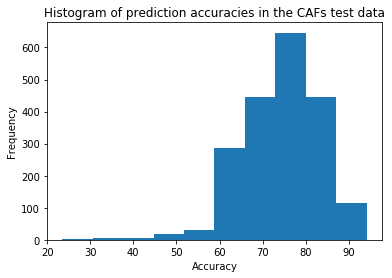

In [25]:
accuracy_list = []
for prob in prob_cafs_test_list:
    pred = np.argmax(prob, axis=1).astype(np.float32)
    accuracy_list.append((pred == np.where(Y_cafs_test)[1]).mean()*100)
    
plt.hist(accuracy_list)
plt.title("Histogram of prediction accuracies in the CAFs test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.show()

In [26]:
np.mean(np.array(accuracy_list))

74.347058823529423

In [27]:
np.std(np.array(accuracy_list))

8.5033659120321285

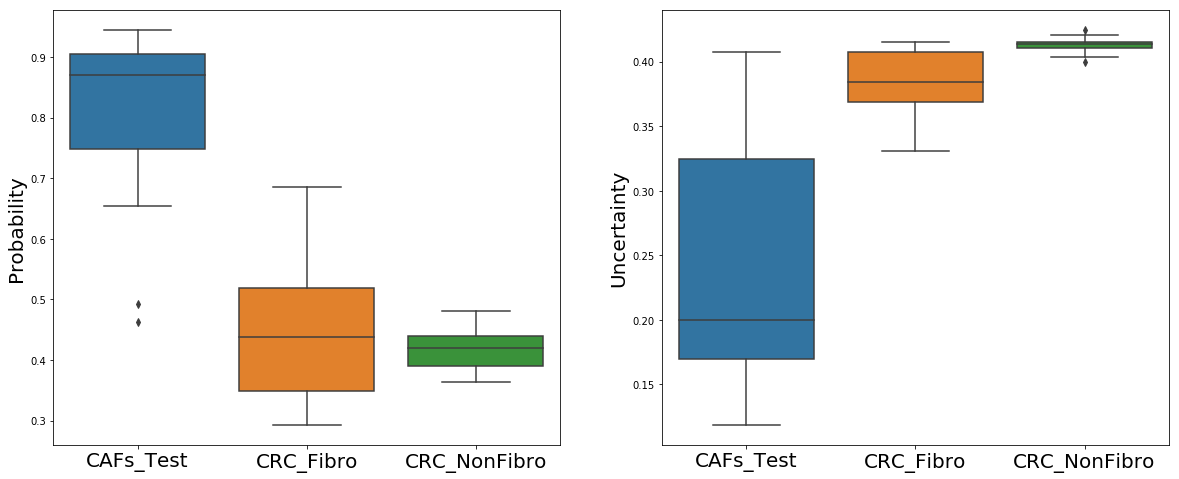

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(20, 8))
#plt.title('Comparison', fontsize = 20)

ax = fig.add_subplot(121)
sns.boxplot(data=[[np.max(i) for i in np.array(prob_cafs_test_list).mean(axis=0)], 
                  [np.max(i) for i in np.array(prob_crc_fibro_list).mean(axis=0)], 
                  [np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).mean(axis=0)]], palette = 'tab10')
plt.ylabel('Probability',fontsize=20)
ax.set_xticklabels(['CAFs_Test','CRC_Fibro','CRC_NonFibro'], fontsize = 20)

ax = fig.add_subplot(122)
sns.boxplot(data=[[np.max(i) for i in np.array(prob_cafs_test_list).std(axis=0)], 
                  [np.max(i) for i in np.array(prob_crc_fibro_list).std(axis=0)], 
                  [np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).std(axis=0)]],
            palette = 'tab10')
plt.ylabel('Uncertainty',fontsize=20)
ax.set_xticklabels(['CAFs_Test','CRC_Fibro','CRC_NonFibro'], fontsize = 20)

plt.show()

In [29]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu([np.max(i) for i in np.array(prob_crc_fibro_list).mean(axis=0)], 
                       [np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).mean(axis=0)])
print('Statistics = %.3f, p = %.3f' % (stat, p))

Statistics = 140.000, p = 0.445


In [30]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu([np.max(i) for i in np.array(prob_crc_fibro_list).std(axis=0)], 
                       [np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).std(axis=0)])
print('Statistics = %.3f, p = %.10f' % (stat, p))

Statistics = 30.000, p = 0.0000430842


In [31]:
np.array(prob_crc_fibro_list).std(axis=0)

array([[ 0.33969465,  0.37767649,  0.37713683,  0.2262021 ],
       [ 0.35566139,  0.20729873,  0.29597071,  0.2150932 ],
       [ 0.29872051,  0.38439798,  0.25044739,  0.12088127],
       [ 0.36929178,  0.28506663,  0.38786536,  0.21732308],
       [ 0.2885744 ,  0.4075397 ,  0.33349937,  0.13909252],
       [ 0.36710337,  0.24004605,  0.38480198,  0.2613816 ],
       [ 0.34618419,  0.36877176,  0.36528322,  0.24846506],
       [ 0.36511669,  0.35802621,  0.36568314,  0.20869085],
       [ 0.3677389 ,  0.30733129,  0.37063849,  0.24332012],
       [ 0.37405124,  0.30889931,  0.34951597,  0.23121224],
       [ 0.35886505,  0.36364025,  0.36631277,  0.21338037],
       [ 0.30528244,  0.41125819,  0.3491109 ,  0.19504288],
       [ 0.28204522,  0.41541195,  0.3528446 ,  0.18076678],
       [ 0.33103424,  0.23404047,  0.19466831,  0.21275556],
       [ 0.3141675 ,  0.40928009,  0.36059302,  0.16938353],
       [ 0.31211945,  0.38590103,  0.39894056,  0.20942634],
       [ 0.36005759,  0.

In [32]:
crc = np.concatenate([np.array([np.max(i) for i in np.array(prob_crc_fibro_list).std(axis=0)]), 
                      np.array([np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).std(axis=0)])])

In [33]:
np.median(np.array([np.max(i) for i in np.array(prob_crc_fibro_list).std(axis=0)]))

0.38439798

In [34]:
np.median(np.array([np.max(i) for i in np.array(prob_crc_all_cells_minus_fibro_list).std(axis=0)]))

0.413726

In [35]:
crc

array([ 0.37767649,  0.35566139,  0.38439798,  0.38786536,  0.4075397 ,
        0.38480198,  0.36877176,  0.36568314,  0.37063849,  0.37405124,
        0.36631277,  0.41125819,  0.41541195,  0.33103424,  0.40928009,
        0.39894056,  0.40733886,  0.41284698,  0.41410831,  0.41440129,
        0.41038218,  0.40398091,  0.41512594,  0.41176945,  0.41405478,
        0.39944571,  0.41979492,  0.42481875,  0.42079154,  0.4112682 ,
        0.40454307,  0.40495348,  0.41613799,  0.413726  ], dtype=float32)

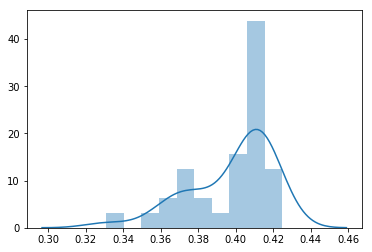

In [39]:
sns.distplot(crc,bins=10)
plt.show()

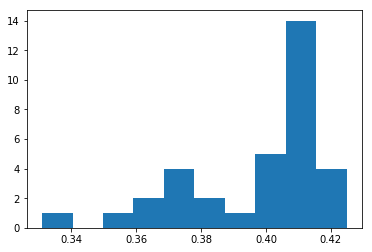

In [40]:
plt.hist(crc,bins=10)
plt.show()

### Making your own MCMC sampler <a class="anchor" id="Making your own MCMC sampler"></a>
In this section we will try to implement some simple MCMC sampler using just Python code. Then we use the sampler to draw samples from a Posterior distribution and compare the results with the Posterior obtained by PyMC3. We will start with loading Python modules and building a toy data set:

### Making your own MCMC sampler <a class="anchor" id="Making your own MCMC sampler"></a>
In this section we will try to implement some simple MCMC sampler using just Python code. Then we use the sampler to draw samples from a Posterior distribution and compare the results with the Posterior obtained by PyMC3. We will start with loading Python modules and building a toy data set:

In [2]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

The toy data set is just a few points drawn from the Normal distribution, let us check how it looks like by plotting the corresponding histogram:

/home/nikolay/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


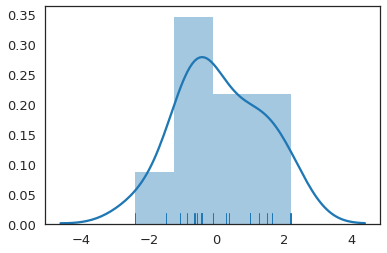

In [3]:
data = np.random.normal(size=20)
sns.distplot(data, rug = True)
plt.show()

Now let us define the model. We assume the Likelihood of observing the data x has Normal distributions with two parameters $\mu$ and $\sigma$, i.e. it has the form $L(x | \mu,\sigma)$. Let us assume that in the scaled case $\sigma = 1$, the Likelihood is $L(x|μ,\sigma) ∼ Normal(x | μ,1)$. Now we have to put a Prior distribution on the mean value $\mu$, we will assume that it follows a Normal distribution as well with mean = 0 and standard deviation = 1, thus our model is given by:

$$
\rm{L}(x|μ,\sigma) ∼ Normal(x | μ,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\prod_{i=1} \exp{\left\{-\frac{(x_i-\mu)^2}{2\sigma^2}\right\}} \\
\rm{Prior}(μ) ∼ Normal(\xi,\tau) = \frac{1}{\sqrt{2\pi\tau^2}}\exp{\left\{-\frac{(\mu-\xi)^2}{2\tau^2}\right\}}
$$

Since we used a conjugate Prior, we can compute the integral in the Bayes formula analytically, [derivation is here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM). The final Posterior distribution will follow Normal distribution:

$$
\rm{Posterior}(μ|x) ∼ Normal(\rm{M},\Sigma) = \frac{1}{\sqrt{2\pi\Sigma^2}}\exp{\left\{-\frac{(\mu-\rm{M})^2}{2\Sigma^2}\right\}} \\
M = \frac{\displaystyle\tau^2N\bar{x}+\sigma^2\xi}{\displaystyle\tau^2N+\sigma^2} \\
\Sigma^2 = \frac{\displaystyle\sigma^2\tau^2}{\displaystyle\tau^2N+\sigma^2}
$$

So here we will define a function which uses the result of analytical Posterior calculation:

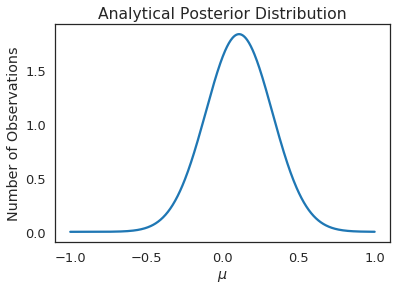

In [4]:
def analytical_posterior(mu, data, xi, tau, sigma):
    N = len(data)
    x_bar = (1/N)*(np.sum(data))
    M = (x_bar*N*tau**2 + xi*sigma**2) / (N*tau**2 + sigma**2)
    Sigma = np.sqrt(((sigma**2)*(tau**2)) / (N*tau**2 + sigma**2))
    return sp.stats.norm(M, Sigma).pdf(mu)

mu = np.linspace(-1, 1, 500)
plt.plot(mu, analytical_posterior(mu, data, 0, 1, 1))
plt.xlabel('$\mu$')
plt.ylabel('Number of Observations')
plt.title('Analytical Posterior Distribution')
plt.show()

Now let us implement our own Metropolis sampler and sample from the Posterior and compare the results with the analytically derived Posterior:

In [5]:
def Metropolis_Sampler(data, mu_init = 1, n_samples = 10):
    mu_current = mu_init
    posterior_sample = [mu_current]
    for i in range(n_samples):
        mu_next = sp.stats.norm(mu_current, 0.5).rvs()
        
        prior_current = sp.stats.norm(0, 1).pdf(mu_current)
        prior_next = sp.stats.norm(0, 1).pdf(mu_next)
        
        likelihood_current = sp.stats.norm(mu_current, 1).pdf(data).prod()
        likelihood_next = sp.stats.norm(mu_next, 1).pdf(data).prod()
        
        posterior_current = likelihood_current*prior_current
        posterior_next = likelihood_next*prior_next
        
        posterior_accept = posterior_next / posterior_current
        if  posterior_accept > np.random.rand():
            mu_current = mu_next
        
        posterior_sample.append(mu_current)
    return posterior_sample

In [6]:
posterior_samples = Metropolis_Sampler(data, 1, 15000)

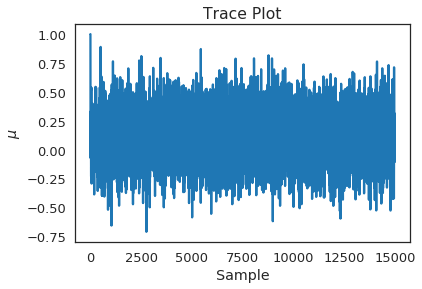

In [7]:
plt.plot(posterior_samples)
plt.xlabel('Sample')
plt.ylabel('$\mu$')
plt.title('Trace Plot')
plt.show()

/home/nikolay/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


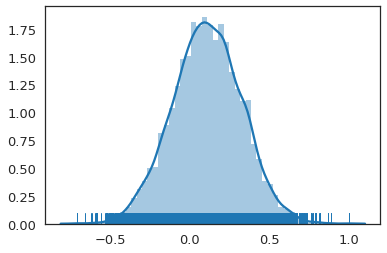

In [8]:
sns.distplot(posterior_samples, rug = True)
plt.show()

/home/nikolay/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


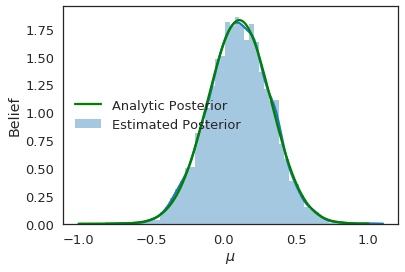

In [9]:
ax = plt.subplot()

sns.distplot(posterior_samples, ax=ax, label='Estimated Posterior')
x = np.linspace(-1, 1, 500)
ax.plot(x, analytical_posterior(x, data, 0, 1, 1), 'g', label='Analytic Posterior')
_ = ax.set(xlabel='$\mu$', ylabel='Belief');
ax.legend();
plt.show()

Now let us use PyMC3 and compare sampling done by PyMC3 with the hand-written Metropolis sampler and the analytical Posterior distributions:

In [11]:
import pymc3 as pm
with pm.Model():
    mu = pm.Normal('mu', 0 ,1)
    sigma = 1
    posterior = pm.Normal('posterior', mu=mu, sd=sigma, observed=data)
    trace = pm.sample(15000, pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
100%|██████████| 15500/15500 [00:01<00:00, 8348.20it/s]
The number of effective samples is smaller than 25% for some parameters.


/home/nikolay/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


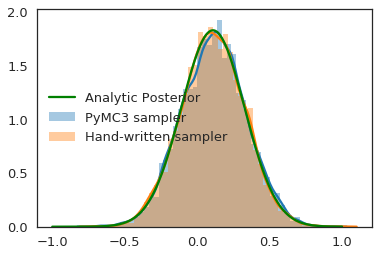

In [13]:
ax = plt.subplot()
sns.distplot(trace['mu'], label='PyMC3 sampler');
sns.distplot(posterior_samples, label='Hand-written sampler');
ax.plot(x, analytical_posterior(x, data, 0, 1, 1), 'g', label='Analytic Posterior')
ax.legend();

We conclude that analytical Posterior, hand-written Metropolis sampler and PyMC3 sampler produce pretty much overlapping Posterior distributions.

### Fitting with Gaussian Process <a class="anchor" id="Fitting with Gaussian Process"></a>

A common applied statistics task involves building regression models to characterize non-linear relationships between variables. It is possible to fit such models by assuming a particular non-linear functional form, such as a sinusoidal, exponential, or polynomial function, to describe one variable’s response to the variation in another. Unless this relationship is obvious from the outset, however, it involves possibly extensive model selection procedures to ensure the most appropriate model is retained. Alternatively, a non-parametric approach can be adopted by defining a set of knots across the variable space and use a spline or kernel regression to describe arbitrary non-linear relationships. However, knot layout procedures are somewhat ad hoc and can also involve variable selection. A third alternative is to adopt a Bayesian non-parametric strategy, and directly model the unknown underlying function. For this, we can employ Gaussian process models.

Describing a Bayesian procedure as “non-parametric” is something of a misnomer. The first step in setting up a Bayesian model is specifying a full probability model for the problem at hand, assigning probability densities to each model variable. Thus, it is difficult to specify a full probability model without the use of probability functions, which are parametric! In fact, Bayesian non-parametric methods do not imply that there are no parameters, but rather that the number of parameters grows with the size of the dataset. Rather, Bayesian non-parametric models are infinitely parametric.

What if we chose to use Gaussian distributions to model our data?

$$
p(x \mid \pi, \Sigma) = (2\pi)^{-k/2}|\Sigma|^{-1/2} \exp\left\{ -\frac{1}{2} (x-\mu)^{\prime}\Sigma^{-1}(x-\mu) \right\}
$$
There would not seem to be any gain in doing this, because normal distributions are not particularly flexible distributions in and of themselves. However, adopting a set of Gaussians (a multivariate normal vector) confers a number of advantages. First, the marginal distribution of any subset of elements from a multivariate normal distribution is also normal:
$$
p(x,y) = \mathcal{N}\left(\left[{
\begin{array}{c}
{\mu_x} \
{\mu_y} \
\end{array}
}\right], \left[{
\begin{array}{cc}
{\Sigma_x} & {\Sigma_{xy}} \\
{\Sigma_{xy}^T} & {\Sigma_y}
\end{array}
}\right]\right)
$$

$$
p(x) = \int p(x,y) dy = \mathcal{N}(\mu_x, \Sigma_x)
$$

Also, conditional distributions of a subset of the elements of a multivariate normal distribution (conditional on the remaining elements) are normal too:

$$
p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y),\Sigma_x-\Sigma{xy}\Sigma_y^{-1}\Sigma{xy}^T)
$$
A Gaussian process generalizes the multivariate normal to infinite dimension. It is defined as an infinite collection of random variables, with any marginal subset having a Gaussian distribution. Thus, the marginalization property is explicit in its definition. Another way of thinking about an infinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially implying an infinite vector that only returns values (indexed by the inputs) when the function is called upon to do so. By the same token, this notion of an infinite-dimensional Gaussian represented as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

So, we can describe a Gaussian process as a distribution over functions. Just as a multivariate normal distribution is completely specified by a mean vector and covariance matrix, a GP is fully specified by a mean function and a covariance function:

$$
p(x) \sim \mathcal{GP}(m(x), k(x,x^{\prime}))
$$
It is the marginalization property that makes working with a Gaussian process feasible: we can marginalize over the infinitely-many variables that we are not interested in, or have not observed.

For example, one specification of a GP might be:

$$
m(x) =0 $$

$$k(x,x^{\prime}) = \theta_1\exp{\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)}
$$

Here, the covariance function is a squared exponential, for which values of $x$ and $x^{\prime}$ that are close together result in values of $k$ closer to one, while those that are far apart return values closer to zero. It may seem odd to simply adopt the zero function to represent the mean function of the Gaussian process — surely we can do better than that! It turns out that most of the learning in the GP involves the covariance function and its hyperparameters, so very little is gained in specifying a complicated mean function.

For a finite number of points, the GP becomes a multivariate normal, with the mean and covariance as the mean functon and covariance function, respectively, evaluated at those points.

In [97]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF, DotProduct

scikit-learn offers a library of about a dozen covariance functions, which they call kernels, to choose from. A flexible choice to start with is the Matèrn covariance.

$$
k_{M}(x) = \frac{\sigma^2}{\Gamma(\nu)2^{\nu-1}} \left(\frac{\sqrt{2 \nu} x}{l}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu} x}{l}\right)
$$

where $\Gamma$ is the gamma function and $K$ is a modified Bessel function. The form of covariance matrices sampled from this function is governed by three parameters, each of which controls a property of the covariance.

* amplitude ($\sigma$) controls the scaling of the output along the y-axis. This parameter is just a scalar multiplier, and is therefore usually left out of implementations of the Matèrn function (i.e. set to one)

* lengthscale ($l$) complements the amplitude by scaling realizations on the x-axis. Larger values push points closer together along this axis.

* roughness ($\nu$) controls the sharpness of ridges in the covariance function, which ultimately affect the roughness (smoothness) of realizations.

Though in general all the parameters are non-negative real-valued, when $\nu = p + 1/2$ for integer-valued $p$, the function can be expressed partly as a polynomial function of order $p$ and generates realizations that are $p$-times differentiable, so values $\nu \in {3/2, 5/2}$ are most common.

A GP kernel can be specified as the sum of additive components in scikit-learn simply by using the sum operator, so we can include a Matèrn component (Matern), an amplitude factor (ConstantKernel), as well as an observation noise (WhiteKernel):

In [109]:
kernel = Matern(length_scale = 1, nu = 3/2)
#kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
#kernel = ConstantKernel() + Matern(length_scale=1, nu=3/2) + WhiteKernel(noise_level=1)
gp = gaussian_process.GaussianProcessRegressor(kernel = kernel, n_restarts_optimizer = 9, alpha=1)
#gp = gaussian_process.GaussianProcessRegressor()
gp.fit(x, y)

/home/nikolay/miniconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00446064]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 4, 'warnflag': 2}
  " state: %s" % convergence_dict)


GaussianProcessRegressor(alpha=1, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=1.5), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [110]:
gp.kernel

Matern(length_scale=1, nu=1.5)

Along with the fit method, each supervised learning class retains a predict method that generates predicted outcomes ($y^{\ast}$) given a new set of predictors ($X^{\ast}$) distinct from those used to fit the model. For a Gaussian process, this is fulfulled by the posterior predictive distribution, which is the Gaussian process with the mean and covariance functions updated to their posterior forms, after having been fit.

$$
p(y^{\ast}|y, x, x^{\ast}) = \mathcal{GP}(m^{\ast}(x^{\ast}), k^{\ast}(x^{\ast}))
$$
where the posterior mean and covariance functions are calculated as:

$$
m^{\ast}(x^{\ast}) = k(x^{\ast},x)^T[k(x,x) + \sigma^2I]^{-1}y $$

$$ k^{\ast}(x^{\ast}) = k(x^{\ast},x^{\ast})+\sigma^2 – k(x^{\ast},x)^T[k(x,x) + \sigma^2I]^{-1}k(x^{\ast},x)
$$

In [111]:
x_pred = np.linspace(-5, 10, num = 100).reshape(-1,1)
y_pred, sigma = gp.predict(x_pred, return_std=True)

In [115]:
y_pred[0:5]

array([[ 261.34695507],
       [ 263.59081158],
       [ 260.77428177],
       [ 253.78676304],
       [ 243.96464648]])

In [116]:
sigma[0:5]

array([ 0.4558604 ,  0.40901638,  0.37480604,  0.3527761 ,  0.3402597 ])

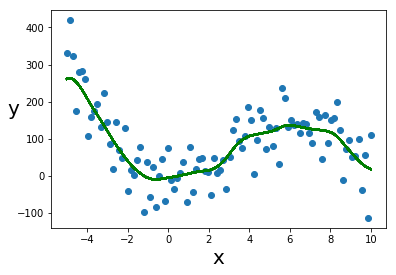

In [113]:
plt.scatter(x, y)
plt.plot(x_pred, y_pred, c='r')
plt.plot(x_pred, y_pred + 2*sigma, c='g')
plt.plot(x_pred, y_pred - 2*sigma, c='g')
plt.xlabel("x",fontsize = 20)
plt.ylabel("y",fontsize = 20, rotation = 0)
plt.show()

### Classification of scRNAseq with TensorFlow <a class="anchor" id="Classification of scRNAseq with TensorFlow"></a>
Here we are going to show how to use TensorFlow to build a nonlinear classifier for a real scRNAseq data det for Cancer-Associated Fibroblasts (CAFs) from K.Pietras project from Lund University. We will start with loading modules, reading and transforming the data. Please note that the last column corresponds to cluster assignment of the cells:

In [1]:
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# READ DATA
expr = pd.read_csv('/home/nikolay/WABI/K_Pietras/Manifold_Learning/bartoschek_filtered_expr_rpkm.txt', sep='\t')
print("\n" + "Dimensions of input file: " + str(expr.shape) + ", that means you have " + str(expr.shape[0]) + 
      " cells and " + str(expr.shape[1]) + " genes remained after filtering" + "\n")
print("\n" + "A few first lines of input file: " + "\n")
print(expr.iloc[0:4, 0:4])
print("\n" + "Last column corresponds to cluster assignments: " + "\n")
print(expr.iloc[0:4, (expr.shape[1]-4):expr.shape[1]])

# LOG-TRANSFORM DATA
X = expr.values[:,0:(expr.shape[1]-1)]
Y = expr.values[:,expr.shape[1]-1]
print("\n" + "A few cluster labels: " + "\n")
print(Y[0:8])
print("\n" + "Number of unique clusters: " + str(len(set(Y))) + "\n")
print("\n" + "You have following unique cluster labels: " + "\n")
print(set(Y))
print("\n" + "Log-transforming data..." + "\n")
X = np.log(X + 1)


Dimensions of input file: (716, 558), that means you have 716 cells and 558 genes remained after filtering


A few first lines of input file: 

                1110020A21Rik  1110046J04Rik  1190002F15Rik  1500015A07Rik
SS2_15_0048_A3            0.0            0.0            0.0            0.0
SS2_15_0048_A6            0.0            0.0            0.0            0.0
SS2_15_0048_A5            0.0            0.0            0.0            0.0
SS2_15_0048_A4            0.0            0.0            0.0            0.0

Last column corresponds to cluster assignments: 

                Zfp652os  Zfp81  Zfp944  cluster
SS2_15_0048_A3       0.0    0.0     0.0        1
SS2_15_0048_A6       0.0    0.0     0.0        1
SS2_15_0048_A5       0.0    0.0     0.0        1
SS2_15_0048_A4       0.0    0.0     0.0        2

A few cluster labels: 

[ 1.  1.  1.  2.  1.  2.  2.  4.]

Number of unique clusters: 4


You have following unique cluster labels: 

{1.0, 2.0, 3.0, 4.0}

Log-transforming data...



Next, we will perform tSNE dimensionality reduction and select only first two tSNE components to train our Neural Network classifier on, so only two dimensions will be used in the further analysis:

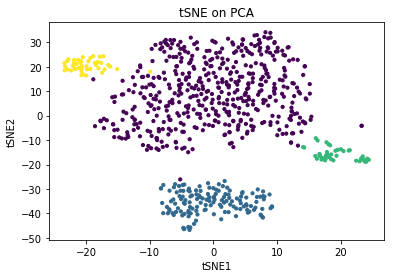

In [2]:
X_reduced = PCA(n_components = 30).fit_transform(X)
model = TSNE(learning_rate = 10, n_components = 2, random_state = 123, perplexity = 30)
tsne = model.fit_transform(X_reduced)
plt.scatter(tsne[:, 0], tsne[:, 1], c = Y, cmap = 'viridis', s = 10)
plt.title('tSNE on PCA')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")
plt.show()

Now we will split the 4-classes data set into train and test subsets while keeping fractions of each class constant, and convert the labels for clusters into one-hot-encoded format: 

In [3]:
X_tsne = tsne[:, 0:2]
Y_tsne = Y

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_tsne, Y_tsne, test_size = 0.4, stratify = None, random_state = 12)

from sklearn.preprocessing import OneHotEncoder
Y_train_original = Y_train
Y_train = np.array( OneHotEncoder().fit_transform(Y_train.reshape(-1, 1)).todense() )
Y_test_original = Y_test
Y_test = np.array( OneHotEncoder().fit_transform(Y_test.reshape(-1, 1)).todense() )
Y_train

array([[ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.]])

Before building the model in TensorFlow, the last thing we need to do is to define a grid for further plotting the decision boundaries of the classifier. The grid is based on X_test, we place equidistantly 100 points from minimal X_test to maximal X_test values, remember those are the tSNE coordinates. Next, we will build a two-dimensional numpy array for each of the 100 x 100 points of the grid, we will execute the classifier at each of those grid points and assign cluster label (with certain softmax probability) to each of the grid points:

In [4]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
print(xx.ravel())
print(yy.ravel())
my_grid_values = np.c_[xx.ravel(), yy.ravel()]
my_grid_values

[-24.37084389 -23.87544243 -23.38004097 ...,  24.17849907  24.67390053
  25.16930199]
[-47.40250778 -47.40250778 -47.40250778 ...,  34.87205505  34.87205505
  34.87205505]


array([[-24.37084389, -47.40250778],
       [-23.87544243, -47.40250778],
       [-23.38004097, -47.40250778],
       ..., 
       [ 24.17849907,  34.87205505],
       [ 24.67390053,  34.87205505],
       [ 25.16930199,  34.87205505]])

Finally, we will build our model in TensorFlow, it is simple one-hidden-layer model, so far we are not building deep neural networks. We will use Adam optimizer to minimize softmax cross entropy since this is a multi-class classification problem. The output layer generates predictions, there are two prediction variables used: 1) pred is for evaluating the model using the true labels from the test data set, 2) pred_my_grid is for assigning a class label to each of the 100 x 100 grid points, this will allow us to visualize decision boundaries later.

Epoch: 1000 cost =  0.018409515
Epoch: 2000 cost =  0.008618979
Epoch: 3000 cost =  0.004742500
Epoch: 4000 cost =  0.002047929
Epoch: 5000 cost =  0.000967472
Epoch: 6000 cost =  0.000471286
Epoch: 7000 cost =  0.000239818
Epoch: 8000 cost =  0.000127405
Epoch: 9000 cost =  0.000069939
Epoch: 10000 cost =  0.000037074


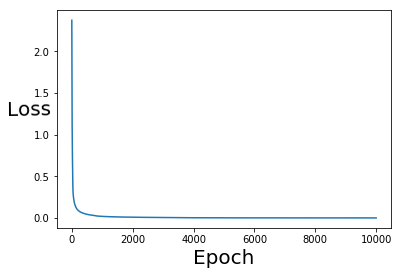

In [5]:
import tensorflow as tf

learning_rate = 0.01
training_epochs = 10000
display_step = 1000

n_samples = X_train.shape[0]
n_classes = len(set(Y))
n_input = X_train.shape[1]
n_hidden = 16

X = tf.placeholder("float")
Y = tf.placeholder("float")

weights = {'w_hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), 
           'w_output': tf.Variable(tf.random_normal([n_hidden, n_classes]))}
biases = {'b_hidden': tf.Variable(tf.random_normal([n_hidden])), 
          'b_output': tf.Variable(tf.random_normal([n_classes]))}

hidden_layer = tf.nn.sigmoid( tf.add( tf.matmul(X, weights['w_hidden']), biases['b_hidden'] ) )
output_layer = tf.add( tf.matmul( hidden_layer, weights['w_output'] ), biases['b_output'] )

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = output_layer, labels = Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

my_cost = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(training_epochs):
        c,_ = sess.run([cost, optimizer], feed_dict={X: X_train, Y: Y_train})
        my_cost.append(c)
        if (epoch + 1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost = ", "{:.9f}".format(c))
    #EVALUATE MODEL
    pred_my_grid = sess.run( tf.nn.softmax(output_layer), feed_dict={X: my_grid_values} )
    pred = sess.run( tf.nn.softmax(output_layer), feed_dict={X: X_test} )
    check_prediction = sess.run( tf.equal(tf.argmax(pred, 1), tf.argmax(Y_test, 1)) )
    accuracy = sess.run( tf.reduce_mean( tf.cast(check_prediction, "float") ) )
plt.plot(range(training_epochs), my_cost)
plt.xlabel("Epoch", fontsize = 20)
plt.ylabel("Loss", fontsize = 20, rotation = 1)
plt.show()

The loss curve reachs its plateau which is a good indication of convergence of our model. Let us now display evaluation results for the test data set. We will build a data frame with correct class labels, predicted labesl as well as a simple True / False check of whether predicted label agrees with the true label. Finally, we display the accuracy value and the confusion matrix where we can see samples for which classes were misclassified.

In [6]:
pred_output = pd.DataFrame({'True': np.array([np.argmax(i) for i in Y_test]),
                          'Pred': np.array([np.argmax(i) for i in pred]),
                           'Check': check_prediction})
print(pred_output.iloc[0:10,0:3])
print("Accuracy:", accuracy)

   Check  Pred  True
0   True     0     0
1   True     1     1
2   True     1     1
3   True     0     0
4   True     0     0
5   True     0     0
6   True     0     0
7   True     0     0
8   True     0     0
9   True     0     0
Accuracy: 0.989547


             precision    recall  f1-score   support

          0       0.98      1.00      0.99       191
          1       1.00      1.00      1.00        57
          2       1.00      0.88      0.94        17
          3       1.00      0.95      0.98        22

avg / total       0.99      0.99      0.99       287



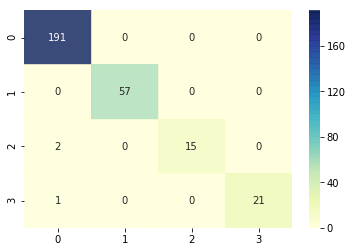

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print(classification_report([np.argmax(i) for i in Y_test], 
                                          [np.argmax(i) for i in np.array([np.round(i) for i in pred])]))
sns.heatmap(pd.DataFrame(confusion_matrix([np.argmax(i) for i in Y_test], 
                                          [np.argmax(i) for i in np.array([np.round(i) for i in pred])] )),
            annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)
plt.show()

Now it is time to draw the decision boundaries for the classifier. This is done by contructing a special 2D array containing predcted class for each point of the 100 x 100 grid. We will utilize the pred_my_grid variable for that purpose:

In [8]:
Z = np.array([np.argmax(i) for i in pred_my_grid])
Z = Z.reshape(xx.shape)
Z

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 0, ..., 0, 0, 0]])

And finally we display the decision boundary using the contourf function from matplotlib. We plot the original tSNE plot for the test data set, and corresponding decision boundaries next to that tSNE plot:

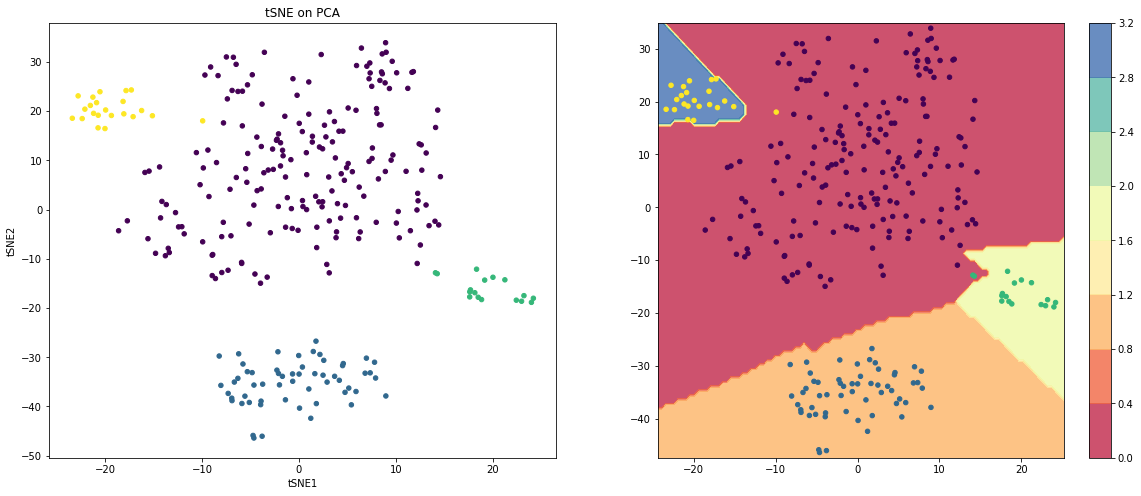

In [9]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.title('tSNE on PCA')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

plt.subplot(122)
plt.contourf(xx, yy, Z, cmap = plt.cm.Spectral, alpha = 0.8)
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

The colors on the tSNE plot with decision boundaries mean belonging to a certain class from 0 to 3 as indicated by the colorbar next to the plot.

Now we are going to do something interesting. We re going to display the probability of assigning each point of the grid to a certain class. The tSNE with decision boundaries above is a categirical, i.e. 0, 1, 2, 3 representation. What if we would like to see what would be a probability of assigning each sample from the test data set to each class. Actually, we have the softmax probability for each class for each sample information stored in the pred_my_grid variable:

In [10]:
print(pred_my_grid)

[[  4.80731444e-07   9.99999404e-01   1.72910063e-07   1.22580426e-08]
 [  4.55923271e-07   9.99999404e-01   1.72402252e-07   1.17622561e-08]
 [  4.34856702e-07   9.99999404e-01   1.71939718e-07   1.13332472e-08]
 ..., 
 [  9.99997377e-01   4.24898391e-14   2.59833587e-06   3.29266388e-12]
 [  9.99997377e-01   4.22762580e-14   2.59256626e-06   3.21872151e-12]
 [  9.99997377e-01   4.20982693e-14   2.58774207e-06   3.15801964e-12]]


Thus we can contruct a data frame where for each sample we have information to which class it is predicted to belong to and the softmax probability of such prediction:

In [11]:
pd.DataFrame({'Class': np.array([np.argmax(i) for i in pred_my_grid]), 
              'Prob': np.array([np.max(i) for i in pred_my_grid])}).iloc[0:10, 0:2]

,Class,Prob
0,1,0.999999
1,1,0.999999
2,1,0.999999
3,1,0.999999
4,1,0.999999
5,1,0.999999
6,1,0.999999
7,1,1.000000
8,1,1.000000
9,1,1.000000


Now we will construct a new Z variable which instead of predicted class will contain the probability of that predicted class. Finally, we will display the probability heatmap on the tSNE plot:

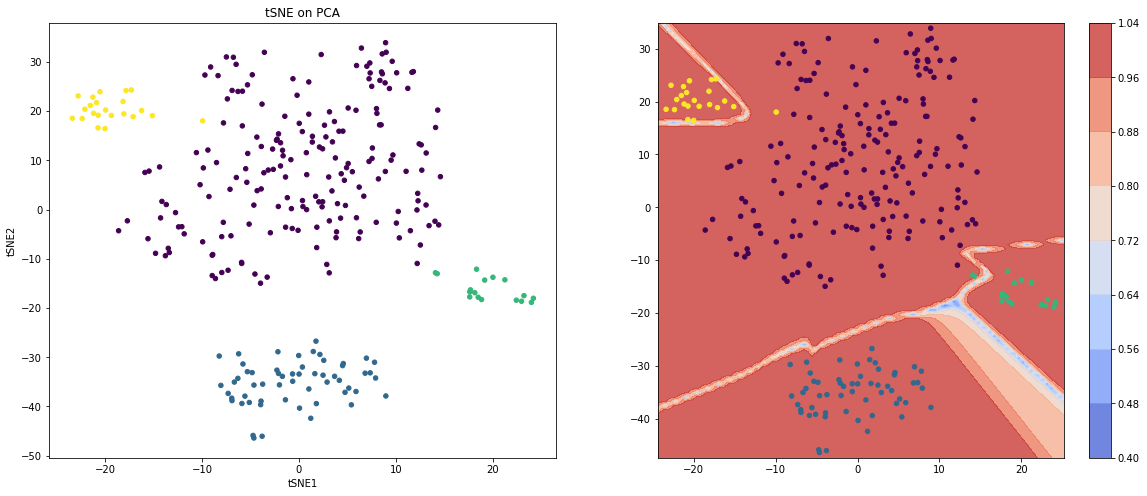

In [12]:
Z_prob = np.array([np.max(i) for i in pred_my_grid])
Z_prob = Z_prob.reshape(xx.shape)
Z_prob

fig = plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.title('tSNE on PCA')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

plt.subplot(122)
plt.contourf(xx, yy, Z_prob, cmap = plt.cm.coolwarm, alpha = 0.8)
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

We can see that most of the regions on the map have a high probability > 90% of assignment to a certain cluster.  However, roughly following the decision boundaries there are zones of lower probability 60%-70%. There is a temptation to say that this gives us an uncertainty of classifier's prediction. But this is not the case! Here we got Maximum Likelihood point estimates for the probability of belonging to a certain class, we need to determine a distributio of such probabilities (a Posterior distribution) in order to get the confidence intervals around the predicted probabilities. The mean of the Posterior distribution will give us the Maximum Likelihood probability displayed on the heatmap above, however the huge benifit of the Posterior is that it will also tell us the uncertainty. Please note 3-4 points which are clearly missclassifed, however their class is assigned with over 90% probability, which is dangerous if we apply this framework to such domains as health care or self-driving cars.

### Bayesian Classification of scRNAseq with PyMC3 and MCMC Sampler <a class="anchor" id="Bayesian Classification of scRNAseq with PyMC3 and MCMC Sampler"></a>

Now we are going to build a Bayesian Neural Network using PyMC3 Python module. The idea behind Bayesian Neural Networks is that weights and biases are not point estimates but they have Prior probabilities. The strength of using PyMC3 is that we can use both MCMC and Variational Inference (VI) approaches, in contrast to Edward which is purely VI-based tool, while it is quite questionable whether VI can completely replace proper samplers for complex Posteriors. Another benifit of PyMC3 is that one can create any model, including Neural Network, and simply run a sampler on the model in the Bayesian fashion. Thus we will start with loading modules, PyMC3 is Theano based so it is especially impoirtant to load theano and theano.tensor, the latter contains the softmax activation function to be used for the output layer:

In [13]:
import theano
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')

Next we are going to contruct a model whcih is a Bayesian Neural Network with one hidden layer and n_hidden neurons. We will assign Normal Priors to weights and biases and initialize them with random values. Within the model we define also the likelihood which is a Categorical distribution since we are dealing with a scRNAseq multi-class (4 classes) classification problem.

In [14]:
def build_bayesian_neural_network(X, Y):
    
    n_samples = X.get_value().shape[0]
    n_classes = Y.get_value().shape[1]
    n_input = X.get_value().shape[1]
    n_hidden = 16
    
    with pm.Model() as model:
        
        # Priors for unknown model parameters
        w_hidden = pm.Normal( 'w_hidden', mu = 0, sd = 1, shape = (n_input, n_hidden), 
                             testval = np.random.randn(n_input, n_hidden) )
        w_output = pm.Normal( 'w_output', mu = 0, sd = 1, shape = (n_hidden, n_classes), 
                             testval = np.random.randn(n_hidden, n_classes) )
        b_hidden = pm.Normal( 'b_hidden', mu = 0, sd = 1, shape = (n_hidden), 
                             testval = np.random.randn(n_hidden) )
        b_output = pm.Normal( 'b_output', mu = 0, sd = 1, shape = (n_classes), 
                             testval = np.random.randn(n_classes) )
        
        # Expected value of outcome
        hidden_layer = pm.math.tanh( pm.math.dot(X.get_value(), w_hidden) + b_hidden )
        output_layer = pm.Deterministic('output_layer', tt.nnet.softmax(pm.math.dot(hidden_layer, w_output) + b_output))
        
        # Likelihood (sampling distribution) of observations
        likelihood = pm.Categorical('likelihood', output_layer, observed = np.where(Y.get_value())[1])
    
    return model

Please note that putting Priors on the weights and biases we let the model know that those parameters have uncertainties, therefore the MCMC sampler will build Posterior distributions for them. However, we are also interested in knowing the Posterior distribution for the prediction of the output layer (which is a combination of input, weights and biases), i.e. not only softmax probabilities for each class but also the confidence intervals for those probabilities. PyMC3 will not track those Posterior distributions by default because we have not explicitly assigned Priors to the output layer. In PyMC3, pm.Deterministic is a way to tell the MCMC sampler to follow that variable (output layer in our case) as well and build a Posterior for that variable.

Now we are going to define a function whcih draws samples from the Posteriors of the parameters of the Bayesian Neural Network using one of the Hamiltonian Monte Carlo (a much faster sampler compared to e.g. Metropolis when derivatives of the parameters can be calculated) algorithms called NUTS.

In [15]:
def train_bayesian_neural_network(model):
    
    with model:
        draws = 1000
        start = pm.find_MAP(maxeval = 10000)
        step = pm.NUTS()
        trace = pm.sample(draws = draws, step = step, start = start)
    
    return trace

Here we used pre-calculated MAP approximation for initiating parameters of the Bayesian Neural Network. You can find information about any PyMC3 method, icluding the MAP approximation thriugh the help available:

In [16]:
help(pm.find_MAP)

Help on function find_MAP in module pymc3.tuning.starting:

find_MAP(start=None, vars=None, method='L-BFGS-B', return_raw=False, include_transformed=True, progressbar=True, maxeval=5000, model=None, *args, **kwargs)
    Finds the local maximum a posteriori point given a model.
    
    Parameters
    ----------
    start : `dict` of parameter values (Defaults to `model.test_point`)
    vars : list
        List of variables to optimize and set to optimum (Defaults to all continuous).
    method : string or callable
        Optimization algorithm (Defaults to 'L-BFGS-B' unless
        discrete variables are specified in `vars`, then
        `Powell` which will perform better).  For instructions on use of a callable,
        refer to SciPy's documentation of `optimize.minimize`.
    return_raw : bool
        Whether to return the full output of scipy.optimize.minimize (Defaults to `False`)
    include_transformed : bool
        Flag for reporting automatically transformed variables in add

Now let us start training the Bayesian Neural Network by using the MCMC sampler for drawing samples from the Posteriors by providing X_train and Y_train data set. Here we use the following trick: we crate shared theano variables and assign X_train and Y_train to them, those variables can be later reset to X_test and Y_test.

For simplicity let us find MAP approximation (point estimate) of the Posterior mean, this should be equivalent to the Maximum Likelihood way from the previous section:

In [17]:
X = theano.shared(X_train)
Y = theano.shared(Y_train)
model = build_bayesian_neural_network(X, Y)
map_estimate = pm.find_MAP(model = model, maxeval = 10000)

logp = -134.54, ||grad|| = 0.09458: 100%|██████████| 1077/1077 [00:01<00:00, 1069.08it/s] 


Now let us check the predictions (class label prediction) of the MAP estimate and compare them with the true labels for the train data set:

In [18]:
print([np.argmax(i) for i in map_estimate['output_layer']])

[2, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 3, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 1, 2, 0, 0, 3, 3, 1, 0, 0, 0, 0, 2, 0, 2, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
print(list(np.where(Y_train)[1]))

[2, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 3, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 1, 2, 0, 0, 3, 3, 1, 0, 0, 0, 0, 2, 0, 2, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
print('Accuracy = {}%'.format((np.where(Y_train)[1] == [np.argmax(i) for i in map_estimate['output_layer']]).mean()*100))

Accuracy = 99.76689976689977%


As expected the accuracy is very high. We knew from the previous section that Maximum Likelyhood approach was able to almost perfectly classify the samples, another reason of course is that accuracy on the training data set is always very high because the parameters of the models are optimized for the train data set.

Now we are going to perform real MCMC samlíng from the Posteriors with NUTS:

In [21]:
%%time
X = theano.shared(X_train)
Y = theano.shared(Y_train)
model = build_bayesian_neural_network(X, Y)
trace = train_bayesian_neural_network(model)

logp = -134.81, ||grad|| = 0.05775: 100%|██████████| 807/807 [00:00<00:00, 1052.67it/s]  
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_output, b_hidden, w_output, w_hidden]
Sampling 2 chains: 100%|██████████| 3000/3000 [07:38<00:00,  2.68draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 9.3 s, sys: 688 ms, total: 9.98 s
Wall time: 7min 42s


The MCMC NUTS sampler built Posteriors for all model parameters including the values on the output layer. The variable trace['output_layer'] is a tensor (3-dimensional array), where first dimension is 2000 samples drawn from the Posterior of the output layer, this number comes from 2 chains x 1000 samples drawn for each chain. Second dimension is the number of samples in the train data set. The third dimension is probabilities of each of the 4 classes. Thus for each cell on the train tSNE plot (429 cells) we have 4 probabilities of assignment to one of the 4 clusters. These probabilities of assignments were drawn 2000 times from from the Posteriors of the output layer. 

In [22]:
trace['output_layer'].shape

(2000, 429, 4)

In [585]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
w_hidden__0_0,-0.023213,0.899073,0.040166,-1.805777e+00,1.806794,305.616713,1.009194
w_hidden__0_1,-0.036105,0.878456,0.040138,-1.792727e+00,1.799165,444.851793,0.999509
w_hidden__0_2,0.016829,0.915390,0.041332,-1.871026e+00,1.895202,352.280892,1.001580
w_hidden__0_3,0.050739,0.909996,0.042890,-1.728498e+00,1.938543,330.743408,1.007078
w_hidden__0_4,-0.062725,0.852002,0.041918,-1.924294e+00,1.734724,344.995860,1.003200
w_hidden__0_5,0.032239,0.934165,0.046444,-1.796137e+00,2.027109,338.719557,1.000094
w_hidden__0_6,0.016037,0.903295,0.046646,-1.668263e+00,1.939130,329.911921,1.002042
w_hidden__0_7,0.085905,0.904080,0.044176,-1.682640e+00,2.018284,318.727352,1.000632
w_hidden__0_8,-0.034783,0.933429,0.039537,-1.937212e+00,1.860515,427.588046,1.000108
w_hidden__0_9,0.001127,0.901489,0.040475,-1.760082e+00,1.878820,373.543723,0.999697


The trace plots can be easily visualized together with the Posterios of the model parameters in PyMC3:

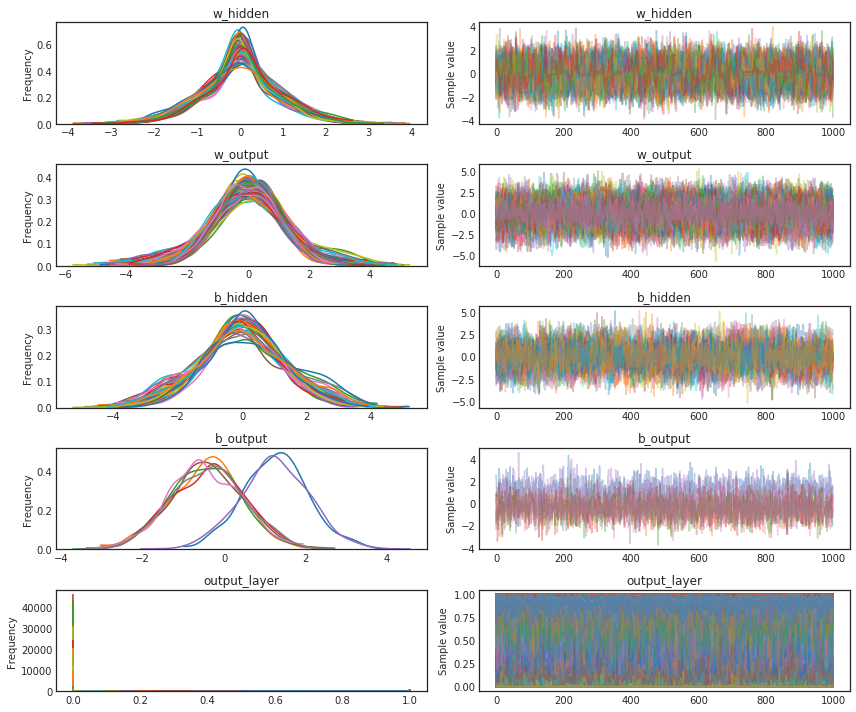

In [23]:
_ = pm.traceplot(trace)
plt.show()

Let us average ove the 2000 samples and create 4 probabilities of assignment to one of the 4 clusters for each of 429 cells, those are predicted labels of the model, we compare them with the true T_train one-hot encoded labels:

In [594]:
print(trace['output_layer'].mean(axis=0))

[[  2.01056548e-02   1.48883256e-02   9.64775156e-01   2.30863543e-04]
 [  9.95805375e-01   1.77096279e-05   1.37408324e-03   2.80283165e-03]
 [  9.97677595e-01   1.79128610e-05   1.24808634e-03   1.05640574e-03]
 ..., 
 [  9.98692576e-01   1.21057225e-05   4.67904754e-04   8.27413570e-04]
 [  1.15772023e-01   5.92720181e-03   1.12471208e-04   8.78188304e-01]
 [  1.16300211e-02   9.82077987e-01   4.90728332e-03   1.38470855e-03]]


In [25]:
Y_train

array([[ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.]])

In [618]:
std_array = trace['output_layer'].std(axis=0)
class_array = np.array([np.argmax(i) for i in trace['output_layer'].mean(axis=0)])
std_class_array = np.array([std_array[i][class_array[j]] 
                            for i,j in zip(range(std_array.shape[0]),range(class_array.shape[0]))])

In [619]:
pd.DataFrame({'Probability': [np.max(i) for i in trace['output_layer'].mean(axis=0)], 'Uncertaintly': std_class_array})

,Probability,Uncertaintly
0,0.964775,0.037585
1,0.995805,0.008115
2,0.997678,0.005247
3,0.886412,0.102961
4,0.996204,0.010017
5,0.995869,0.007856
6,0.997512,0.006326
7,0.984341,0.014678
8,0.989138,0.012980
9,0.998837,0.003464


We can also convert the one-hot encoded representation to 0, 1, 2, 3 cluster labels, now it is a bit easier to visually compare predictions with the true labels:

In [26]:
print([np.argmax(i) for i in trace['output_layer'].mean(axis=0)])

[2, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 3, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 1, 2, 0, 0, 3, 3, 1, 0, 0, 0, 0, 2, 0, 2, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 0, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

In [28]:
print(list(np.where(Y_train)[1]))

[2, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 1, 3, 1, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 3, 0, 0, 1, 2, 0, 0, 3, 3, 1, 0, 0, 0, 0, 2, 0, 2, 3, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 0, 0, 1, 0, 1, 0, 3, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 3, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 2, 3, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 

The accuracy of predictions is of course very high due to evaluating the model on the training data set:

In [29]:
print('Accuracy={}%'.format((np.where(Y_train)[1]==[np.argmax(i)for i in trace['output_layer'].mean(axis=0)]).mean()*100))

Accuracy=99.3006993006993%


Now let us display the predicted and true Categorical distribution of the labels, they clearly look very similar and have 4 peaks corresponding to the 4 classes:

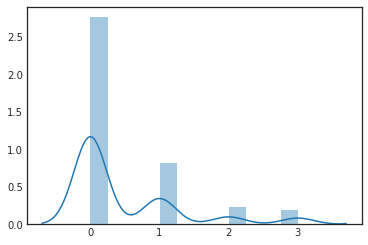

In [30]:
import seaborn as sns
sns.distplot([np.argmax(i) for i in trace['output_layer'].mean(axis=0)])
plt.show()

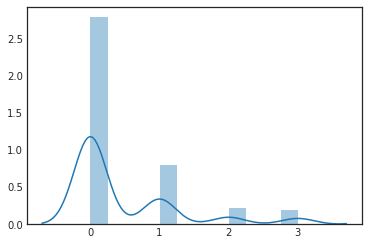

In [31]:
import seaborn as sns
sns.distplot(np.where(Y_train)[1])
plt.show()

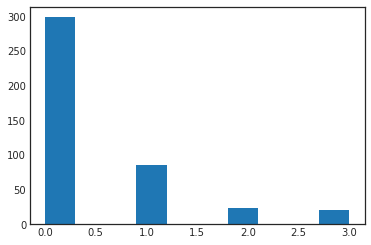

In [32]:
plt.hist(np.where(Y_train)[1])
plt.show()

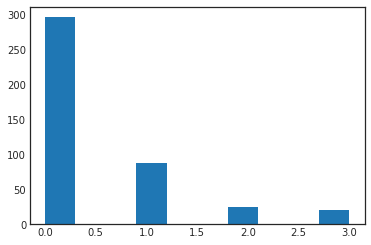

In [33]:
plt.hist([np.argmax(i) for i in trace['output_layer'].mean(axis=0)])
plt.show()

Finally, let us critisize the model by applying a Posterior Predictive Check (PPC) on the hold-out test dat set. PPC randomly selects 500 samples from the Posteriors of the parameters of the trained Bayesian Neural Network and builds a Normal distribution centered around each of the 500 drawn values. Then it draws 100 samples from those 500 distributions. This is equivalent to checking how well our model can generate data which resemble as much as possible true Posterior.

In [34]:
# Replace shared variables with testing set
X.set_value(X_test)
Y.set_value(Y_test)
model = build_bayesian_neural_network(X, Y)

# Create posterior predictive samples
ppc = pm.sample_posterior_predictive(trace, model = model, samples = 500, random_seed = 0)

pred = ppc['likelihood'].mean(axis=0)

100%|██████████| 500/500 [00:07<00:00, 72.65it/s]


In [35]:
ppc['likelihood'].shape

(500, 287)

In [38]:
ppc['likelihood']

array([[0, 1, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ..., 
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 0, 1]])

Finally the accuracy calculated on the hold-out test data set, i.e. the ultimate model evaluation accuracy is:

In [37]:
print('Accuracy = {}%'.format((np.where(Y_test)[1] == np.round(pred)).mean() * 100))

Accuracy = 95.81881533101046%


This is a very good validation accuracy! Finally, let us compare predictions on the test data set with the true Y_test labels:

In [47]:
print(list(np.round(pred)))

[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 0.0, 3.0, 0.0, 1.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 3.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0,

In [48]:
print(list(np.where(Y_test)[1]))

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 2, 1, 0, 3, 0, 1, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2, 0, 1, 0, 1, 0, 0, 1, 3, 1, 3, 1, 3, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 0, 0, 3, 0, 0, 0, 1, 3, 0, 3, 0, 2, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0, 2, 2, 1, 0, 3, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 3, 0, 0, 0, 2, 0, 1, 0, 0, 0, 3, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 3, 0, 1, 0, 0, 0, 3, 3, 0, 0, 0, 1]


Again, now we are going to display the tSNE plot together with decision boundaries. For this purpose we need to create a 100 x 100 grid and run model prediction on each point of the grid:

In [49]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
print(xx.ravel())
print(yy.ravel())
my_grid_values = np.c_[xx.ravel(), yy.ravel()]
my_grid_values

[-24.37084389 -23.87544243 -23.38004097 ...,  24.17849907  24.67390053
  25.16930199]
[-47.40250778 -47.40250778 -47.40250778 ...,  34.87205505  34.87205505
  34.87205505]


array([[-24.37084389, -47.40250778],
       [-23.87544243, -47.40250778],
       [-23.38004097, -47.40250778],
       ..., 
       [ 24.17849907,  34.87205505],
       [ 24.67390053,  34.87205505],
       [ 25.16930199,  34.87205505]])

The variable my_grid_values has 2 dimensions as well as X_train or X_test, just with more observations / samples.

In [414]:
my_grid_values.shape

(10201, 2)

In [416]:
X_test.shape

(287, 2)

The grid points are our new X variable, we will also create a dummy Y variable which we will feed to PPC. The Y variable (labels) is dummy because we actually have already trained our Bayesian Neural Network using X_train, so now we only need an X variable (input data) but not the labels to evaluate the model on the grid using Posterior Predictive Check (PPC) procedure. The labels will be calculated / predicted by the model. However we can run PPC in PyMC3 only using a model as a context, an the model has 2 input variables X and Y, this implies we need to feed some dummy variable Y just to follow the model syntax. It is important that the dimensions of the dummy variable are identical to Y_test and Y_train. Therefore, we pretend that all 10201 points on the grid belong to the class label 1 (out of class labels 0, 1, 2, 3), i.e. use [0,1,0,0] as an array of probabilities to belong to a certain class.

In [462]:
dummy_out = np.array([[0,1,0,0]]*10201)
dummy_out.shape

(10201, 4)

Let us run PPC on the new variables X = my_grid_values and Y = dummy_out: 

In [469]:
# Replace shared variables with testing set
X.set_value(np.float32(my_grid_values))
Y.set_value(np.float32(dummy_out))
model = build_bayesian_neural_network(X, Y)

# Create posterior predictive samples
ppc = pm.sample_posterior_predictive(trace, model = model, samples = 500, random_seed = 0)

100%|██████████| 500/500 [03:59<00:00,  2.13it/s]


The output of the PPC procedure is an array with 500 elements, each element is an array of 10201 cluster assignments (labels) based on the trace from the Posterior distribution calculated previously. Averaging across the 500 samples gives us a prediction (label assignment) for each point on the grid.

In [514]:
ppc['likelihood']

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 2, 1, ..., 0, 0, 0],
       ..., 
       [0, 1, 1, ..., 3, 3, 3],
       [3, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [620]:
ppc['likelihood'].mean(axis=0)[0:100]

array([ 1.012,  1.014,  1.01 ,  0.988,  1.012,  1.01 ,  1.01 ,  0.988,
        1.028,  1.028,  1.032,  1.002,  1.032,  0.996,  1.04 ,  1.006,
        1.006,  1.02 ,  1.008,  1.01 ,  1.006,  0.998,  1.01 ,  1.   ,
        0.998,  1.022,  1.018,  1.014,  1.004,  1.004,  1.002,  1.01 ,
        1.002,  1.006,  1.002,  1.004,  1.002,  1.004,  0.996,  1.002,
        1.004,  1.   ,  1.   ,  0.996,  1.002,  0.992,  1.01 ,  1.004,
        0.996,  1.004,  1.002,  1.002,  1.004,  1.006,  1.01 ,  1.006,
        1.002,  1.008,  1.008,  1.004,  1.002,  1.002,  1.002,  1.008,
        1.012,  1.   ,  1.   ,  1.01 ,  0.994,  1.014,  1.006,  1.014,
        1.018,  1.01 ,  1.006,  1.016,  1.034,  1.04 ,  1.068,  1.044,
        1.072,  1.09 ,  1.128,  1.112,  1.126,  1.108,  1.174,  1.164,
        1.212,  1.224,  1.216,  1.206,  1.226,  1.222,  1.284,  1.284,
        1.3  ,  1.31 ,  1.31 ,  1.34 ])

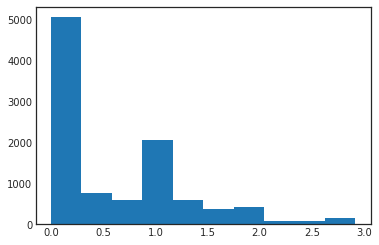

In [512]:
plt.hist(ppc['likelihood'].mean(axis=0))
plt.show()

So the mean Posterior prediction should be one of the 4 numbers: 0, 1, 2 or 3. However from the histogram of those predictions we can see that some points on the grid have cluster assignment e.g. 0.5 or 1.34. What does it mean? We should convert those values into probabilities of assignment to a certain class and plot decision boundaries like we did in the previous section. 

In [568]:
np.array([i[0] for i in ppc['likelihood']]).shape

(500,)

In [578]:
ppc['likelihood'].shape

(500, 10201)

In [579]:
my_probs = []
for j in range(ppc['likelihood'].shape[1]):
    my_probs.append([sum(np.array([i[j] for i in ppc['likelihood']]) == 0) / ppc['likelihood'].shape[0],
                    sum(np.array([i[j] for i in ppc['likelihood']]) == 1) / ppc['likelihood'].shape[0],
                    sum(np.array([i[j] for i in ppc['likelihood']]) == 2) / ppc['likelihood'].shape[0],
                    sum(np.array([i[j] for i in ppc['likelihood']]) == 3) / ppc['likelihood'].shape[0]])
my_probs

[[0.14399999999999999, 0.754, 0.048000000000000001, 0.053999999999999999],
 [0.13600000000000001,
  0.76400000000000001,
  0.050000000000000003,
  0.050000000000000003],
 [0.11799999999999999,
  0.79200000000000004,
  0.051999999999999998,
  0.037999999999999999],
 [0.126, 0.79600000000000004, 0.042000000000000003, 0.035999999999999997],
 [0.11600000000000001,
  0.79600000000000004,
  0.048000000000000001,
  0.040000000000000001],
 [0.091999999999999998,
  0.83799999999999997,
  0.037999999999999999,
  0.032000000000000001],
 [0.094, 0.83599999999999997, 0.035999999999999997, 0.034000000000000002],
 [0.106, 0.83399999999999996, 0.025999999999999999, 0.034000000000000002],
 [0.078, 0.85199999999999998, 0.034000000000000002, 0.035999999999999997],
 [0.073999999999999996,
  0.85799999999999998,
  0.034000000000000002,
  0.034000000000000002],
 [0.059999999999999998, 0.88400000000000001, 0.02, 0.035999999999999997],
 [0.075999999999999998,
  0.86799999999999999,
  0.034000000000000002,
  0

In [580]:
Z_prob = np.array([np.max(i) for i in np.array(my_probs)])
Z_prob = Z_prob.reshape(xx.shape)
Z_prob

array([[ 0.754,  0.764,  0.792, ...,  0.572,  0.556,  0.514],
       [ 0.722,  0.756,  0.766, ...,  0.528,  0.494,  0.506],
       [ 0.72 ,  0.736,  0.754, ...,  0.522,  0.53 ,  0.486],
       ..., 
       [ 0.894,  0.866,  0.856, ...,  0.982,  0.99 ,  0.996],
       [ 0.886,  0.848,  0.848, ...,  0.982,  0.986,  0.994],
       [ 0.84 ,  0.826,  0.806, ...,  0.994,  0.984,  0.99 ]])

In [649]:
Z_prob_list = []
for k in range(100):
    X.set_value(np.float32(my_grid_values))
    Y.set_value(np.float32(dummy_out))
    model = build_bayesian_neural_network(X, Y)
    ppc1 = pm.sample_posterior_predictive(trace, model = model, samples = 500)
    
    my_probs1 = []
    for j in range(ppc1['likelihood'].shape[1]):
        my_probs1.append([sum(np.array([i[j] for i in ppc1['likelihood']]) == 0) / ppc1['likelihood'].shape[0],
                          sum(np.array([i[j] for i in ppc1['likelihood']]) == 1) / ppc1['likelihood'].shape[0],
                          sum(np.array([i[j] for i in ppc1['likelihood']]) == 2) / ppc1['likelihood'].shape[0],
                          sum(np.array([i[j] for i in ppc1['likelihood']]) == 3) / ppc1['likelihood'].shape[0]])
    Z_prob1 = np.array([np.max(i) for i in np.array(my_probs1)])
    Z_prob_list.append(Z_prob1)

100%|██████████| 500/500 [03:56<00:00,  2.11it/s]


In [650]:
Z_prob_mean = np.array(Z_prob_list).mean(axis=0)
Z_prob_mean = Z_prob_mean.reshape(xx.shape)
Z_prob_std = np.array(Z_prob_list).std(axis=0)
Z_prob_std = Z_prob_std.reshape(xx.shape)
Z_prob_std

array([[ 0.0121573 ,  0.01352951,  0.01345065, ...,  0.0148471 ,
         0.01397804,  0.01339188],
       [ 0.01254654,  0.01359553,  0.01310731, ...,  0.01402425,
         0.01366483,  0.01446556],
       [ 0.01280392,  0.01349778,  0.01335178, ...,  0.01391149,
         0.0129154 ,  0.01242596],
       ..., 
       [ 0.01006531,  0.01078228,  0.0136543 , ...,  0.0046603 ,
         0.00438634,  0.0044463 ],
       [ 0.0113688 ,  0.01225398,  0.01219219, ...,  0.00429003,
         0.00433271,  0.00481979],
       [ 0.01151618,  0.01481216,  0.01426178, ...,  0.00507086,
         0.00386451,  0.00399079]])

In [517]:
ppc['likelihood'].mean(axis=0)[0:100]

array([ 1.012,  1.014,  1.01 ,  0.988,  1.012,  1.01 ,  1.01 ,  0.988,
        1.028,  1.028,  1.032,  1.002,  1.032,  0.996,  1.04 ,  1.006,
        1.006,  1.02 ,  1.008,  1.01 ,  1.006,  0.998,  1.01 ,  1.   ,
        0.998,  1.022,  1.018,  1.014,  1.004,  1.004,  1.002,  1.01 ,
        1.002,  1.006,  1.002,  1.004,  1.002,  1.004,  0.996,  1.002,
        1.004,  1.   ,  1.   ,  0.996,  1.002,  0.992,  1.01 ,  1.004,
        0.996,  1.004,  1.002,  1.002,  1.004,  1.006,  1.01 ,  1.006,
        1.002,  1.008,  1.008,  1.004,  1.002,  1.002,  1.002,  1.008,
        1.012,  1.   ,  1.   ,  1.01 ,  0.994,  1.014,  1.006,  1.014,
        1.018,  1.01 ,  1.006,  1.016,  1.034,  1.04 ,  1.068,  1.044,
        1.072,  1.09 ,  1.128,  1.112,  1.126,  1.108,  1.174,  1.164,
        1.212,  1.224,  1.216,  1.206,  1.226,  1.222,  1.284,  1.284,
        1.3  ,  1.31 ,  1.31 ,  1.34 ])

Let us use the digits after the decimal point and check how they are reletively different from 0.5 (random). For this purpose we 1) take the digits after the decimal point, 2) sabtruct 0.5, 3) take absolute value of the difference, 4) divide the result by 0.5. This will give us a mean probability of belonging to only one class.

In [525]:
np.abs(ppc['likelihood'].mean(axis=0)[0:100] % 1 - 0.5) / 0.5

array([ 0.976,  0.972,  0.98 ,  0.976,  0.976,  0.98 ,  0.98 ,  0.976,
        0.944,  0.944,  0.936,  0.996,  0.936,  0.992,  0.92 ,  0.988,
        0.988,  0.96 ,  0.984,  0.98 ,  0.988,  0.996,  0.98 ,  1.   ,
        0.996,  0.956,  0.964,  0.972,  0.992,  0.992,  0.996,  0.98 ,
        0.996,  0.988,  0.996,  0.992,  0.996,  0.992,  0.992,  0.996,
        0.992,  1.   ,  1.   ,  0.992,  0.996,  0.984,  0.98 ,  0.992,
        0.992,  0.992,  0.996,  0.996,  0.992,  0.988,  0.98 ,  0.988,
        0.996,  0.984,  0.984,  0.992,  0.996,  0.996,  0.996,  0.984,
        0.976,  1.   ,  1.   ,  0.98 ,  0.988,  0.972,  0.988,  0.972,
        0.964,  0.98 ,  0.988,  0.968,  0.932,  0.92 ,  0.864,  0.912,
        0.856,  0.82 ,  0.744,  0.776,  0.748,  0.784,  0.652,  0.672,
        0.576,  0.552,  0.568,  0.588,  0.548,  0.556,  0.432,  0.432,
        0.4  ,  0.38 ,  0.38 ,  0.32 ])

Thus we create a mean probability variable for the decision heatmap and plot the heatmap which shows high mean probability of assignment to a class by red and low mean probability of assignment to a class by blue. The heatmap basically re-creates the decision boundaries obtained in the previous section by the Maximum Likelihood approach. 

In [527]:
Z = (np.abs(ppc['likelihood'].mean(axis=0) % 1 - 0.5) / 0.5).reshape(xx.shape)

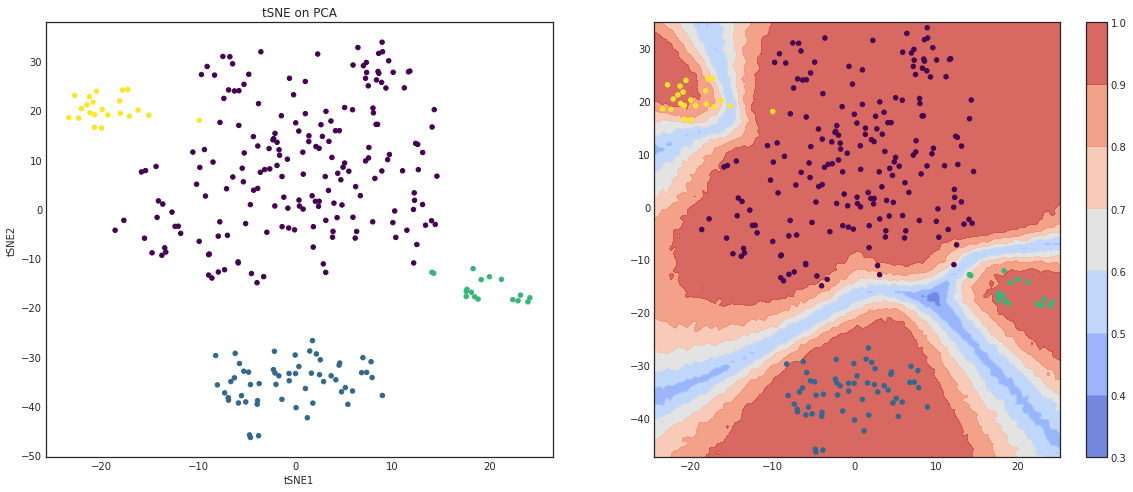

In [581]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.title('tSNE on PCA')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

plt.subplot(122)
plt.contourf(xx, yy, Z_prob, cmap = plt.cm.coolwarm, alpha = 0.8)
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

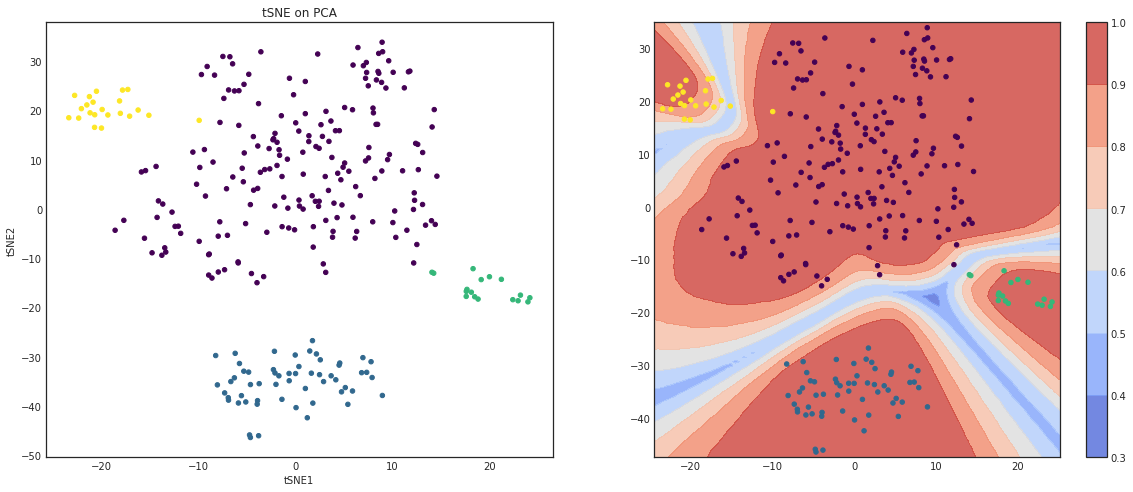

In [651]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.title('tSNE on PCA')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

plt.subplot(122)
plt.contourf(xx, yy, Z_prob_mean, cmap = plt.cm.coolwarm, alpha = 0.8)
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

Now we will calculate standard deviation, i.e. uncertainty of cluster assignment from the Posterior distribution:

In [499]:
Z = ppc['likelihood'].std(axis=0).reshape(xx.shape)

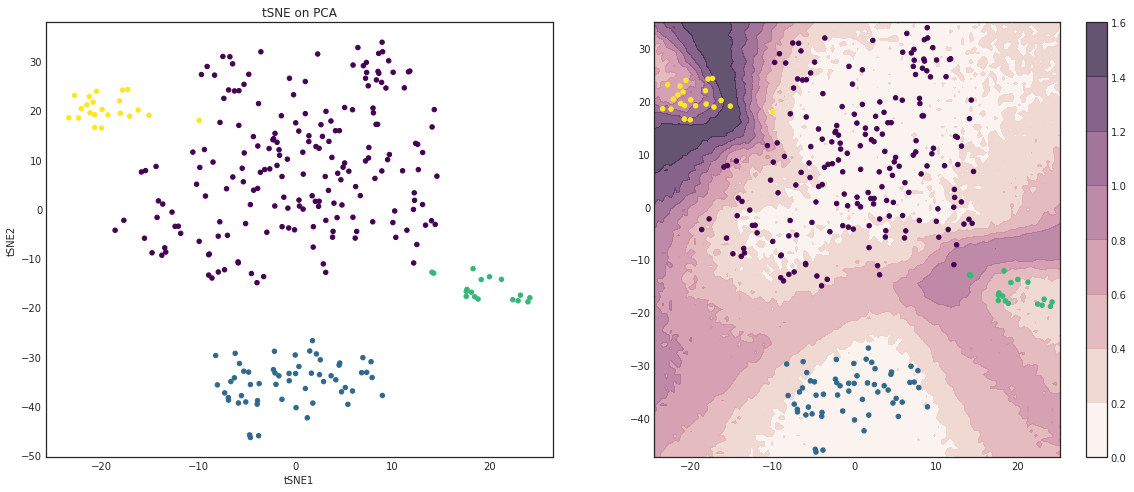

In [500]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.title('tSNE on PCA')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

plt.subplot(122)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.contourf(xx, yy, Z, cmap = cmap, alpha = 0.8)
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

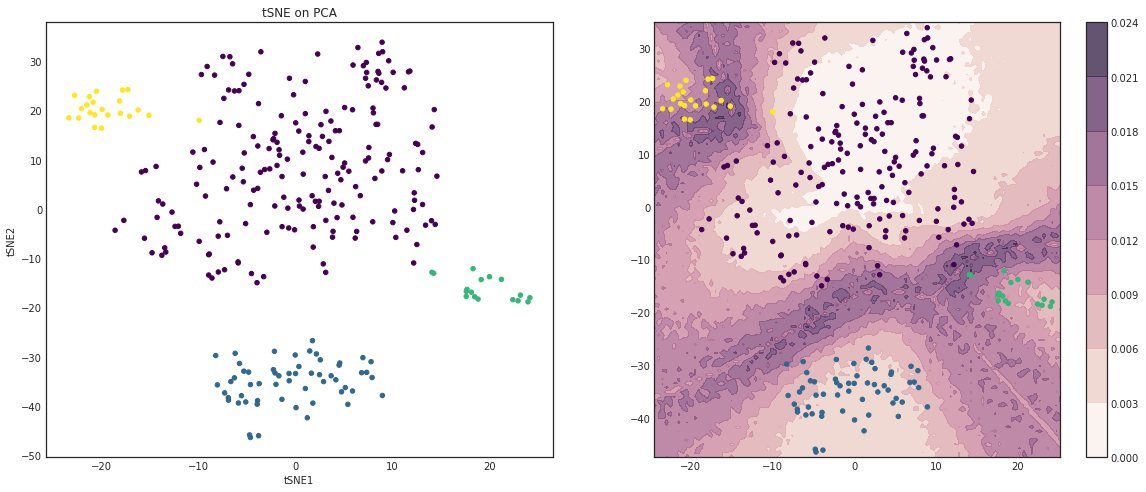

In [652]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.title('tSNE on PCA')
plt.xlabel("tSNE1")
plt.ylabel("tSNE2")

plt.subplot(122)
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.contourf(xx, yy, Z_prob_std, cmap = cmap, alpha = 0.8)
plt.colorbar()
plt.scatter(X_test[:, 0], X_test[:, 1], c = Y_test_original, cmap = 'viridis', s = 20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

We can see that the region between the purple and the yeallow cluster demonstrates especially high uncertainty of assignment of a cell from that region to either cluster. The same but less pronounced effect is visible for the boundary between the purple and the green cluster. Thus for each cell from the hold-out test data set we have a probability of assignment to a cluster and a measure of how uncertain is this probability.

In [653]:
pd.DataFrame({'Cluster': np.round(ppc['likelihood'].mean(axis=0)),
              'Probability': np.array(Z_prob_list).mean(axis=0),
             'Uncertanty': np.array(Z_prob_list).std(axis=0)}).iloc[0:10,0:3]

,Cluster,Probability,Uncertanty
0,1.0,0.76260,0.012157
1,1.0,0.77218,0.013530
2,1.0,0.78660,0.013451
3,1.0,0.79670,0.011608
4,1.0,0.80838,0.013792
5,1.0,0.81940,0.012932
6,1.0,0.83164,0.012084
7,1.0,0.83844,0.010942
8,1.0,0.84630,0.012446
9,1.0,0.85852,0.011702


In [553]:
pd.DataFrame({'Cluster': np.round(ppc['likelihood'].mean(axis=0)),
              'Probability': np.abs(ppc['likelihood'].mean(axis=0) % 1 - 0.5) / 0.5,
             'Uncertanty': ppc['likelihood'].std(axis=0)}).iloc[0:10,0:3]

,Cluster,Probability,Uncertanty
0,1.0,0.976,0.638636
1,1.0,0.972,0.621131
2,1.0,0.980,0.567362
3,1.0,0.976,0.558441
4,1.0,0.976,0.569083
5,1.0,0.980,0.507839
6,1.0,0.980,0.515655
7,1.0,0.976,0.517548
8,1.0,0.944,0.505189
9,1.0,0.944,0.493169


### Bayesian Classification of scRNAseq with PyMC3 and Variational Inference <a class="anchor" id="Bayesian Classification of scRNAseq with PyMC3 and Variational Inference"></a>

MCMC sampler is precise but very slow especially for Deep Neural Networks. An alternative is to use the concept of Variational Inference which implies that we build a Normal approximator to the true Posterior via minimization of Kullback-Leibler divergence between the two distributions and sample from that Normal approximator. This procedure is implemented as ADVI algorithm in PyMC3.

In [654]:
def build_bayesian_neural_network(X, Y):
    
    n_samples = X.get_value().shape[0]
    n_classes = Y.get_value().shape[1]
    n_input = X.get_value().shape[1]
    n_hidden = 16
    
    with pm.Model() as model:
        
        # Priors for unknown model parameters
        w_hidden = pm.Normal( 'w_hidden', mu = 0, sd = 1, shape = (n_input, n_hidden), 
                             testval = np.random.randn(n_input, n_hidden) )
        w_output = pm.Normal( 'w_output', mu = 0, sd = 1, shape = (n_hidden, n_classes), 
                             testval = np.random.randn(n_hidden, n_classes) )
        b_hidden = pm.Normal( 'b_hidden', mu = 0, sd = 1, shape = (n_hidden), 
                             testval = np.random.randn(n_hidden) )
        b_output = pm.Normal( 'b_output', mu = 0, sd = 1, shape = (n_classes), 
                             testval = np.random.randn(n_classes) )
        
        # Expected value of outcome
        hidden_layer = pm.math.tanh( pm.math.dot(X.get_value(), w_hidden) + b_hidden )
        output_layer = pm.Deterministic('output_layer', tt.nnet.softmax(pm.math.dot(hidden_layer, w_output) + b_output))
        
        # Likelihood (sampling distribution) of observations
        likelihood = pm.Categorical('likelihood', output_layer, observed = np.where(Y.get_value())[1])
    
    return model

Now we will use Variational Bayes approach with ADVI algorithm and create an approximation for the Posterior.

In [656]:
%%time
X = theano.shared(X_train)
Y = theano.shared(Y_train)
neural_network = build_bayesian_neural_network(X, Y)
with neural_network:
    approx = pm.fit(n = 50000, method = pm.ADVI())

Average Loss = 172.26: 100%|██████████| 50000/50000 [00:25<00:00, 1997.35it/s]
Finished [100%]: Average Loss = 172.03


CPU times: user 27.1 s, sys: 1.01 s, total: 28.1 s
Wall time: 32.7 s


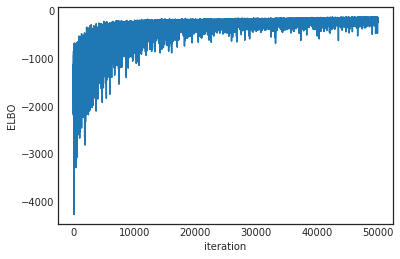

In [657]:
plt.plot(-approx.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration')
plt.show()

Now let us draw samples (traces) from the approximation to the Posterior for the weights of the Bayesian Neural Network, this is because samples are easier to visualize and work with. We can visualize the Posterior distributions for all weights together with trace plots:

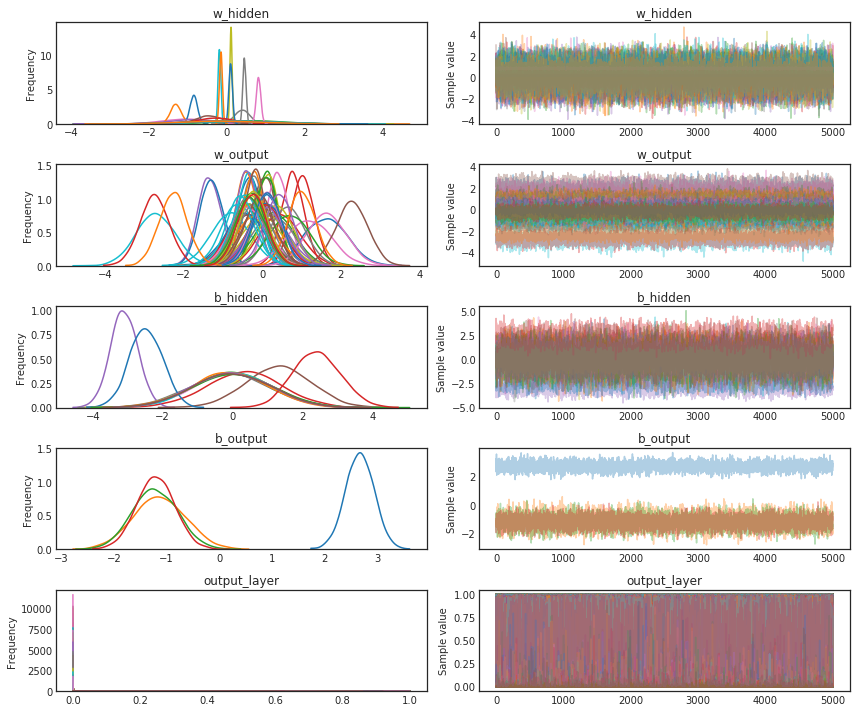

In [658]:
%%time
trace = approx.sample(draws = 5000)
pm.traceplot(trace)
plt.show()

In [659]:
set([np.argmax(i) for i in trace['output_layer'].mean(axis=0)])

{0, 1, 2, 3}

In [661]:
print(trace['output_layer'].mean(axis=0))

[[  8.56815456e-02   7.17936566e-02   8.41442887e-01   1.08191067e-03]
 [  9.88363973e-01   7.09522917e-06   1.08902248e-03   1.05399094e-02]
 [  9.88983437e-01   1.45395470e-05   1.77009805e-03   9.23192566e-03]
 ..., 
 [  9.88194612e-01   6.57967416e-06   1.00387613e-03   1.07949322e-02]
 [  4.45160387e-01   4.71106688e-03   2.25344762e-05   5.50106011e-01]
 [  1.93489511e-02   9.48600780e-01   2.69899519e-02   5.06031721e-03]]


In [662]:
Y_train

array([[ 0.,  0.,  1.,  0.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  0.]])

In [663]:
set(np.where(Y_train)[1])

{0, 1, 2, 3}

In [664]:
print('Accuracy={}%'.format((np.where(Y_train)[1]==[np.argmax(i)for i in trace['output_layer'].mean(axis=0)]).mean()*100))

Accuracy=98.36829836829837%


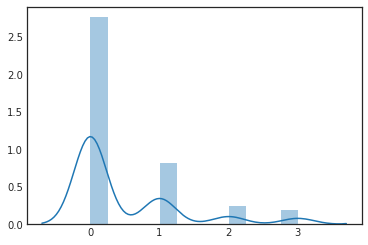

In [665]:
import seaborn as sns
sns.distplot([np.argmax(i) for i in trace['output_layer'].mean(axis=0)])
plt.show()

We can see that hidden weights comprise two (number of input features n_input) one-dimensional numpy arrays each of length n_hidden. The output weights represent 16 one-dimensional numpy arrays each of length 4 since there are 4 classes. Now that we trained our model, let us proceed with model validation and predict on the test data set using a posterior predictive check (PPC).

In [682]:
%%time

# Replace shared variables with testing set
X.set_value(X_test)
Y.set_value(Y_test)
model = build_bayesian_neural_network(X, Y)

# Create posterior predictive samples
ppc = pm.sample_posterior_predictive(trace, model = model, samples = 10000)

pred = ppc['likelihood'].mean(axis=0)

100%|██████████| 10000/10000 [02:19<00:00, 71.85it/s]

CPU times: user 2min 19s, sys: 908 ms, total: 2min 20s
Wall time: 2min 19s


In [683]:
ppc['likelihood']

array([[0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ..., 
       [0, 1, 2, ..., 0, 3, 1],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 0, 1]])

In [684]:
ppc['likelihood'].mean(axis=0)

array([ 0.0892,  1.0272,  0.9706,  0.0353,  0.034 ,  0.1315,  0.0744,
        0.03  ,  0.0941,  0.0343,  0.2956,  0.0272,  0.0297,  1.7407,
        0.0318,  1.6711,  0.0308,  0.0802,  0.1408,  0.0369,  0.1262,
        0.0352,  0.1037,  1.1957,  1.7794,  1.0254,  0.0383,  1.7454,
        0.1553,  1.0278,  1.7703,  1.4258,  0.0331,  0.0388,  0.0244,
        0.0265,  0.0311,  0.1017,  0.0374,  0.0332,  0.091 ,  1.032 ,
        1.6935,  0.0305,  0.1845,  0.0281,  1.0343,  0.0344,  0.028 ,
        0.0655,  0.0317,  1.0279,  1.1565,  0.0369,  1.2799,  0.0333,
        0.0318,  0.1025,  0.0286,  0.0277,  1.0189,  1.7218,  0.0957,
        0.0167,  0.2219,  1.0257,  1.7234,  1.4602,  0.0154,  0.0315,
        0.0311,  0.0311,  0.0316,  0.7231,  0.0938,  0.03  ,  1.5084,
        0.0272,  0.0293,  1.0238,  0.0336,  0.0293,  0.0601,  1.0237,
        1.0274,  0.0625,  0.0972,  0.1675,  1.0332,  1.0248,  0.0167,
        0.0237,  0.0229,  0.0351,  0.0278,  0.0344,  0.1037,  1.0204,
        0.0268,  0.0

In [685]:
set(np.round(ppc['likelihood'].mean(axis=0)))

{0.0, 1.0, 2.0}

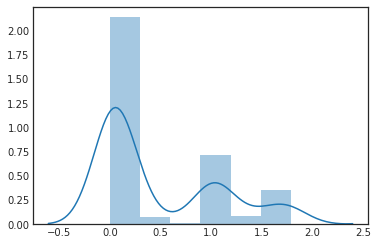

In [686]:
import seaborn as sns
sns.distplot(ppc['likelihood'].mean(axis=0))
plt.show()

In [687]:
pred = np.round(ppc['likelihood'].mean(axis=0)) + 1
print('Accuracy = {}%'.format((Y_test_original == pred).mean() * 100))

Accuracy = 89.54703832752612%
